In [11]:
import pandas as pd
import numpy as np
import pickle

import seaborn as sns
%matplotlib inline

from sklearn import metrics #Used for the Feature Selection
from sklearn.ensemble import ExtraTreesClassifier #Used for the Feature Selection
from sklearn.preprocessing import LabelEncoder

from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler  # For scaling dataset
#from sklearn.cluster import KMeans 
from sklearn.cluster import KMeans, SpectralClustering #For clustering
from sklearn.neighbors import LocalOutlierFactor #For LOF

from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix,f1_score

import os                     # For os related operations
import sys                    # For data size

import Cluster_model
import plotting

np.random.seed(0) 
pd.set_option('display.float_format', lambda x: '%.3f' % x) # Format / Surpress Exponential notation

# ignore warnings from pandas
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500) #View max number columns
pd.set_option('display.max_rows', 500) #View max number columns


In [12]:
import warnings
warnings.filterwarnings('ignore')

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
%matplotlib inline

In [14]:
import importlib
importlib.reload(plotting) 
from plotting import *
importlib.reload(Cluster_model) 
from Cluster_model import *

In [23]:
dataloc = '/Users/marionaidoo/Library/Mobile Documents/com~apple~CloudDocs/GitHub/MscResearch/MscAnomaly - GANS/Deep Learning - Unsupervised GANS/Medicare/GitHub-Copy/GANS-Anomaly-Detection'
plotloc = '/Users/marionaidoo/Library/Mobile Documents/com~apple~CloudDocs/GitHub/MscResearch/MscAnomaly - GANS/Deep Learning - Unsupervised GANS/Medicare/GitHub-Copy/GANS-Anomaly-Detection/plots/'
modelsloc = '/Users/marionaidoo/Library/Mobile Documents/com~apple~CloudDocs/GitHub/MscResearch/MscAnomaly - GANS/Deep Learning - Unsupervised GANS/Medicare/GitHub-Copy/GANS-Anomaly-Detection/cache/'
dfprefix = 'Medicare'

model = 'GAN'

In [24]:
#Select 20% of data from Main dataset
datafrac = 0.1 # fraction from the engineering notebook - DONOT change
DLsampledata = 0.2 # can be changed. Use a percentage to speed up testing

## Extracting Data from Zipped File

In [30]:
## extracting zip file
import zipfile

def main():

    # assigning filename to a variable
    file_name = 'data/' + dfprefix + '_' + str(datafrac) + 'MedicareDatasetFinal.engineered.pkl.zip'

    # opening Zip using 'with' keyword in read mode
    with zipfile.ZipFile(file_name, 'r') as file:
        # printing all the information of archive file contents using 'printdir' method
        print(file.printdir())

        # extracting the files using 'extracall' method
        print('Extracting all files...')
        file.extractall(path= dfprefix + '_' + str(datafrac) + 'MedicareDatasetFinal.engineered.pkl')
        print('Done!') # check your directory of zip file to see the extracted files

if __name__ == '__main__': main()

File Name                                             Modified             Size
Medicare_0.1MedicareDatasetFinal.engineered.pkl 2020-04-14 11:45:46    574757025
None
Extracting all files...
Done!


In [32]:
#Save Engineered Dataset
#pickle.dump(mspRedData_Final, open('data/' + 'RMAmedical_GANS.engineered.pkl','wb'))

#Load pickle data
#mspRedData_Final = pickle.load(open('data/' + dfprefix + '_' + str(datafrac) + '_Unsupervised_PercentData.engineered.pkl','rb'))
#mspRedData = pickle.load(open('data/' + dfprefix + '_' + str(datafrac) + 'MedicareDatasetFinal.engineered.pkl','rb'))
zipfolder = 'Medicare_0.1MedicareDatasetFinal.engineered.pkl/'
mspRedData = pickle.load(open(zipfolder + dfprefix + '_' + str(datafrac) + 'MedicareDatasetFinal.engineered.pkl','rb'))



In [33]:
mspRedData['IsSuspiciousInd'] = np.where(mspRedData['AVERAGE_MEDICARE_PAYMENT_AMT'] <= mspRedData['AveragePaymentAmountPerTypeCode'], 0, 1)

In [34]:
mspRedData_Final  = mspRedData.sample(frac=DLsampledata)

In [35]:
mspRedData_Final.shape, mspRedData.shape

((199567, 71), (997834, 71))

In [36]:
# def correlation(dataset, threshold):
#     col_corr = set() # Set of all the names of deleted columns
#     corr_matrix = dataset.corr()
#     for i in range(len(corr_matrix.columns)):
#         for j in range(i):
#             if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
#                 colname = corr_matrix.columns[i] # getting the name of column
#                 col_corr.add(colname)
#                 if colname in dataset.columns:
#                     del dataset[colname] # deleting the column from the dataset

#     return dataset


In [37]:
#Remove features that have a correlation
# mspRedData_Final = correlation(mspRedData_Final,0.8) 

In [38]:
mspRedData_Final.dtypes

PracTypeClean_General Surgery                                     int64
PracTypeClean_Nurse Practitioner                                  int64
PracTypeClean_Physician Assistant                                 int64
PracTypeClean_Internal Medicine                                   int64
PracTypeClean_Pathology                                           int64
PracTypeClean_Hematology-Oncology                                 int64
PracTypeClean_Nephrology                                          int64
PracTypeClean_Ophthalmology                                       int64
PracTypeClean_Family Practice                                     int64
PracTypeClean_Cardiovascular Disease (Cardiology)                 int64
PracTypeClean_Orthopedic Surgery                                  int64
PracTypeClean_Diagnostic Radiology                                int64
PracTypeClean_Emergency Medicine                                  int64
PracTypeClean_Urology                                           

In [39]:
NumericVar = ['AVERAGE_MEDICARE_PAYMENT_AMT',                                 
            'AveragePaymentAmountPerTypeCode',                    
            'Average_SRVC_CountPerCodeType',              
            'Average_UNIQUE_CountPerCodeType',             
            'Average_DAY_SRVC_CountPerCodeType',          
            'Average_SRVC_DEVIDED_BY_Average_UNIQUE']
mspRedData_Final[NumericVar]= mspRedData_Final[NumericVar].astype(float)

IntVar = ['IsSuspiciousInd']
mspRedData_Final[IntVar]= mspRedData_Final[IntVar].astype(int)

In [40]:
np.random.seed(0)

n_real = np.sum(mspRedData_Final.IsSuspiciousInd==0) # 968814
n_test = np.sum(mspRedData_Final.IsSuspiciousInd==1) # 29020

n_real,n_test

(100481, 99086)

In [41]:
train_fraction = 0.8
fn_real = int(n_real * train_fraction)
fn_test = int(n_test * train_fraction)

test_cols = mspRedData_Final.columns


In [42]:
real_samples = mspRedData_Final.loc[ mspRedData_Final.IsSuspiciousInd==0, test_cols].sample(n_real, replace=False).reset_index(drop=True)
test_samples = mspRedData_Final.loc[ mspRedData_Final.IsSuspiciousInd==1, test_cols].sample(n_test, replace=False).reset_index(drop=True)

In [43]:
train_df = real_samples[:fn_real]

#train_df = pd.concat([real_samples[:fn_real],test_samples[:fn_test]],axis=0,ignore_index=True).reset_index(drop=True)
# train_df = pd.concat([real_samples[:fn_test],test_samples[:fn_test]],axis=0,ignore_index=True).reset_index(drop=True)

test_df = pd.concat([real_samples[fn_real:],test_samples[fn_test:]],axis=0,ignore_index=True).reset_index(drop=True)
print( 'classes 0, 1: ', n_real, n_test )
print( 'train, test: ', len(train_df), len(test_df) )

classes 0, 1:  100481 99086
train, test:  80384 39915


In [44]:
trainx_col = train_df.columns[:-1]
trainy_col = train_df.columns[-1]

testx_col = test_df.columns[:-1]
testy_col = test_df.columns[-1]

In [45]:
trainx = train_df[trainx_col]
trainy = train_df[trainy_col]

testx = test_df[testx_col]
testy = test_df[testy_col]

In [46]:
#Split datat to Train(60) ,dev(20) and test (20)
#trainx, validx,testx = np.split(mspRedData_Final.sample(frac=1), [int(.6*len(mspRedData_Final)), int(.8*len(mspRedData_Final))])

In [47]:
#Reset Indexes
trainx = trainx.reset_index(drop = True)
testx = testx.reset_index(drop = True)
#validx = validx.reset_index(drop = True)

In [48]:
trainx.shape,testx.shape

((80384, 70), (39915, 70))

### Scaling of Data
Standardization of Numeric variables

In [217]:
numerics = ['float16', 'float32', 'float64']
data_cols = mspRedData_Final.select_dtypes(include=numerics).columns  

In [218]:
outliers_fraction = 0.1

In [219]:
#standardize the  distribution
# Create the Scaler object
scaler = preprocessing.StandardScaler()

#Fit and transform the Train, tEst and Validate dataset
trainx[data_cols] = scaler.fit_transform(trainx[data_cols])
testx[data_cols] = scaler.fit_transform(testx[data_cols])
#validx[data_cols] = scaler.fit_transform(validx[data_cols])

#trainx = scaler.fit_transform(trainx)
#testx = scaler.fit_transform(testx)

#x_train_std = scaler.fit_transform(x_train)
#x_valid_std = scaler.fit_transform(x_valid)
#x_test_std = scaler.fit_transform(x_test)


## Load from Saved previous GROUND TRUTH model
IF you load from a saved model ingore running the K-Means model/section

In [193]:
#Save Ground Truth Dataset
#pickle.dump(ytest, open('data/' + 'GroundTruth_GANS.engineered.pkl','wb'))


#Load GROUND TRUTH DATA 
#ytest = pickle.load(open('data/' + 'GroundTruth_GANS.engineered.pkl','rb'))
ytest = testy # Taken from the sample dataset


## UnSupervised Clustering Algorithms

### 1. K- Means

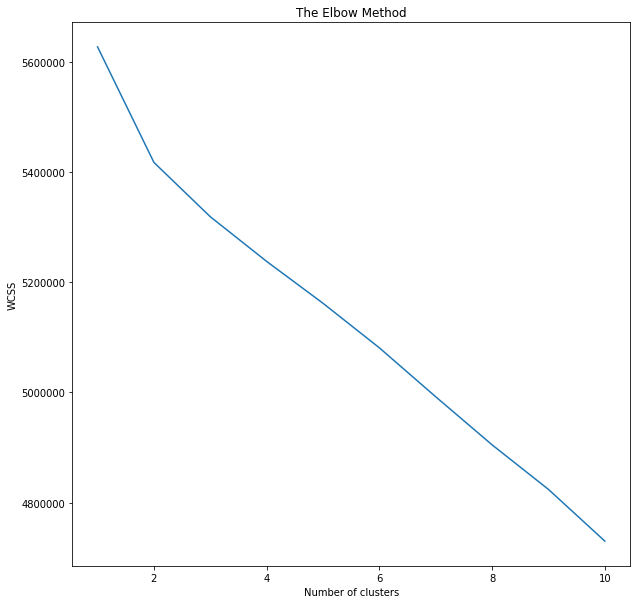

In [194]:
# ---------K-Means Clustering-----------
## Get the number of CLuster for K-Means
# find the appropriate cluster number
plt.figure(figsize=(10, 10))

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(trainx)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [16]:
#%%time

# TSNE is an interesting method to map higher dimensional data into two dimensions
# http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

# Note TSNE map may not be what you might think:
# https://distill.pub/2016/misread-tsne/

# Create multiple projections to compare results from different random states

#from sklearn.manifold import TSNE

#projections = [TSNE(random_state=i).fit_transform(trainx) for i in range(3) ]


In [105]:
###K- Means Model ---TRAIN MODEL
num_clust = 6
kmeans_model,x_clusters,x_clust_center,km_y_pred = Cluster_model.get_kMeans(trainx,outliers_fraction,n_clust = num_clust)

#kmeans_model,x_clusters,x_clust_center,km_y_pred = Cluster_model.get_kMeans(pca_train,pca_test,outliers_fraction,n_clust = 5)

# save the model to disk
dataext = 'non_pca'
filename = 'KMeans_GANS'+ dataext +'.sav'
pickle.dump(kmeans_model, open(modelsloc + filename, 'wb'))

In [106]:
x_clusters

,PracTypeClean_General Surgery,PracTypeClean_Nurse Practitioner,PracTypeClean_Physician Assistant,PracTypeClean_Internal Medicine,PracTypeClean_Pathology,PracTypeClean_Hematology-Oncology,PracTypeClean_Nephrology,PracTypeClean_Ophthalmology,PracTypeClean_Family Practice,PracTypeClean_Cardiovascular Disease (Cardiology),PracTypeClean_Orthopedic Surgery,PracTypeClean_Diagnostic Radiology,PracTypeClean_Emergency Medicine,PracTypeClean_Urology,PracTypeClean_Gastroenterology,PracTypeClean_Interventional Cardiology,PracTypeClean_Audiologist,PracTypeClean_Clinical Laboratory,PracTypeClean_Physical Therapist in Private Practice,PracTypeClean_Neurology,PracTypeClean_Anesthesiology,PracTypeClean_Infectious Disease,PracTypeClean_Neurosurgery,PracTypeClean_Podiatry,PracTypeClean_Thoracic Surgery,PracTypeClean_Vascular Surgery,PracTypeClean_Optometry,PracTypeClean_Ambulatory Surgical Center,PracTypeClean_General Practice,PracTypeClean_Pulmonary Disease,PracTypeClean_Dermatology,PracTypeClean_Physical Medicine and Rehabilitation,"PracTypeClean_Psychologist, Clinical",PracTypeClean_Obstetrics & Gynecology,PracTypeClean_Geriatric Medicine,PracTypeClean_Medical Oncology,PracTypeClean_Rheumatology,PracTypeClean_Radiation Oncology,PracTypeClean_Otolaryngology,PracTypeClean_Interventional Pain Management,PracTypeClean_Certified Registered Nurse Anesthetist (CRNA),PracTypeClean_Mass Immunizer Roster Biller,PracTypeClean_Allergy/ Immunology,PracTypeClean_Interventional Radiology,PracTypeClean_Pain Management,PracTypeClean_Other,PracTypeClean_Psychiatry,PracTypeClean_Independent Diagnostic Testing Facility (IDTF),PracTypeClean_Cardiac Surgery,PracTypeClean_Centralized Flu,PracTypeClean_Endocrinology,PracTypeClean_Clinical Cardiatric Electrophysiology,PracTypeClean_Chiropractic,PracTypeClean_Critical Care (Intensivists),PracTypeClean_Occupational Therapist in Private Practice,PracTypeClean_Ambulance Service Provider,PracTypeClean_Licensed Clinical Social Worker,PracTypeClean_Anesthesiology Assistant,PracTypeClean_Plastic and Reconstructive Surgery,PracTypeClean_Oral Surgery (Dentists only),PracTypeClean_Certified Clinical Nurse Specialist,PracTypeClean_Pediatric Medicine,PracTypeClean_Registered Dietitian or Nutrition Professional,PracTypeClean_Colorectal Surgery (Proctology),AVERAGE_MEDICARE_PAYMENT_AMT,AveragePaymentAmountPerTypeCode,Average_SRVC_CountPerCodeType,Average_UNIQUE_CountPerCodeType,Average_DAY_SRVC_CountPerCodeType,Average_SRVC_DEVIDED_BY_Average_UNIQUE,0_x,0_y
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.613,0.429,-0.044,-0.114,-0.027,-0.028,0,0.000
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1.622,1.233,0.029,0.399,0.053,-0.028,0,0.000
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.348,-0.333,0.171,1.489,0.163,-0.028,2,0.000
3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.172,-0.204,-0.047,-0.140,-0.030,-0.028,2,0.000
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.241,0.114,-0.044,-0.114,-0.027,-0.028,2,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80379,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.292,-0.221,-0.040,-0.078,-0.023,-0.028,2,0.000
80380,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.36

In [22]:
#trainx.drop(['Id'], axis = 1, inplace=True)

Use the Euclidean Distance between centres for each cluster and thereafter calculate the anomaly base done a 0.1/99% outlier criteria
Will use the K-Means as the GROUND TRUTH (i.e y_pred) for comparision of model performance.

In [104]:
#Combing the TRAIN dataset with the Cluster information
train_km_pca_df = x_clusters 
#pd.concat([trainx, pd.DataFrame(x_clusters)], axis=1) # combining the kMeans data with Pca data for reportin
train_km_pca_df.rename(columns={'0_x': 'ClusterNumber',
                         '0_y': 'AnomalyInd'}, inplace=True)
 
#km_pca_df = pd.concat([km_pca_df, pd.DataFrame(km_y_pred)], axis=1) 
#km_pca_df.rename(columns={0: 'AnomalyInd'}, inplace=True)

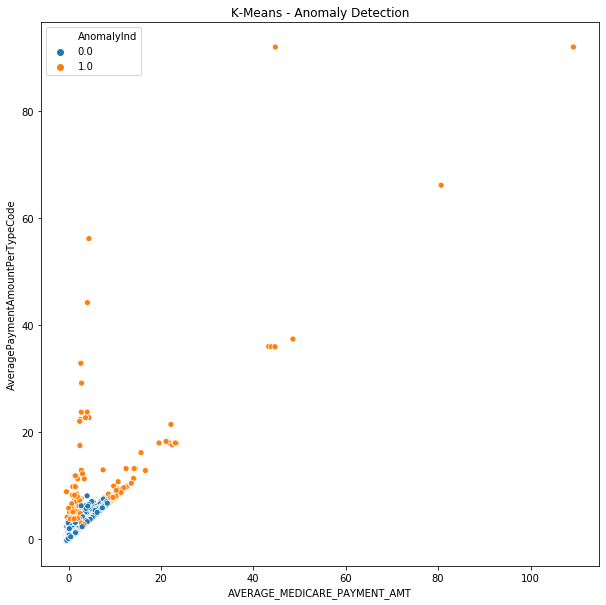

In [107]:
ax = plotting.get_clusterplots(train_km_pca_df,'K-Means',plotloc,'KmeansAnomalyPlot_GANS','AVERAGE_MEDICARE_PAYMENT_AMT','AveragePaymentAmountPerTypeCode')

In [25]:
# %%time 
# ## Needs MORE development to determin the anomaly 
# algorithms = [ 
#     [ 'KMeans', KMeans, (), {'n_clusters':num_clust, 'random_state':0} ],
#     [ 'iforest', IsolationForest, (), {'max_samples':100, 'random_state':42, 'behaviour':"new", 'contamination': 0.1} ],
#     [ 'LOF', LocalOutlierFactor, (), {'n_neighbors':20, 'algorithm':'auto', 'leaf_size':30,'metric':'minkowski','contamination':0.1,'novelty':False} ],
#     [ 'OneClassSVM', OneClassSVM, (), {'kernel':'linear','gamma':'auto', 'coef0':0.0, 'tol':0.001, 'nu':0.1, 'shrinking':True, 'cache_size':500, 'verbose':False, 'max_iter':-1} ],
    
# ]

# rows = len(algorithms)
# columns = 4
# plt.figure(figsize=(columns*3, rows*3))

# for i, [name, algorithm, args, kwds] in enumerate(algorithms):
#     print(i, name)

#     labels = algorithm(*args, **kwds).fit_predict(trainx)
#     pd.DataFrame( [ [np.sum(labels==i)] for i in np.unique(labels) ], columns=['count'], index=np.unique(labels) ) 
    
#     colors = np.clip(labels,-1,9)
#     colors = [ 'C'+str(i) if i>-1 else 'black' for i in colors ]
    
#     plt.subplot(rows,columns,i*columns+1)
#     plt.scatter(trainx[data_cols[0]], trainx[data_cols[1]], c=colors)
#     plt.xlabel(data_cols[0]), plt.ylabel(data_cols[1])
#     plt.title(name)

#     for j in range(3):
#         plt.subplot(rows,columns,i*columns+1+j+1)
#         plt.scatter(*(projections[j].T), c=colors) 
#         plt.xlabel('x'), plt.ylabel('y')
#         plt.title('TSNE projection '+str(j+1),size=12)
        
# #     break

# plt.suptitle('Comparison of Anomaly Clusters', size=16)
# plt.tight_layout(rect=[0,0,1,0.95])
# plt.savefig(plotloc + 'Cluster Anomaly Diagram_GANS.png')
# plt.show()

Evaluate the various plots across each feature based on the K-Means Anomaly flag

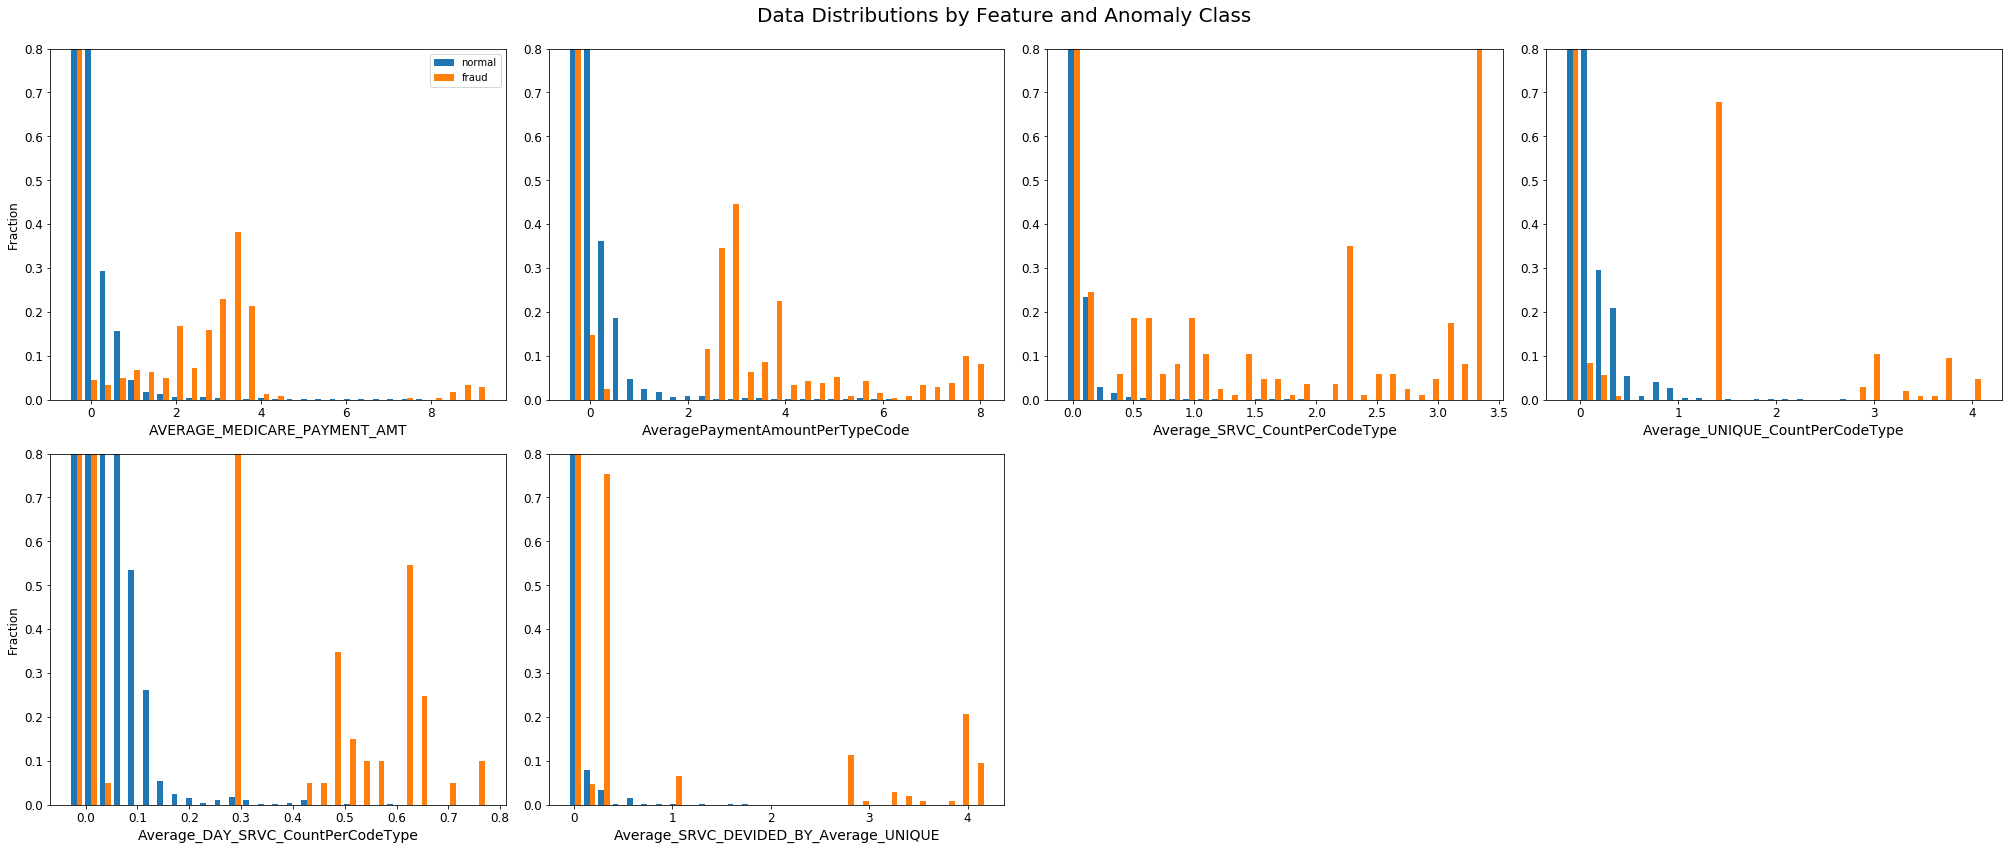

In [108]:
# Plot the data by each feature across the traing set

data = train_km_pca_df

axarr = [[]]*len(data_cols)
columns = 4
rows = int( np.ceil( len(data_cols) / columns ) )
f, fig = plt.subplots( figsize=(columns*7, rows*6) )

f.suptitle('Data Distributions by Feature and Anomaly Class', size=20)

for i, col in enumerate(data_cols[:]):
    axarr[i] = plt.subplot2grid( (int(rows), int(columns)), (int(i//columns), int(i%columns)) )
    axarr[i].hist( [ data.loc[ data.AnomalyInd == 0, col ], data.loc[ data.AnomalyInd == 1, col ] ], label=['normal','fraud'], 
                          bins=np.linspace( np.percentile(data[col],0.1), np.percentile(data[col],99.9), 30 ),
                          normed=True )
    axarr[i].set_xlabel(col, size=14)
    axarr[i].set_ylim([0,0.8])
    axarr[i].tick_params(axis='both', labelsize=12)
    if i == 0: 
        legend = axarr[i].legend()
        legend.get_frame().set_facecolor('white')
    if i%4 != 0 : 
        axarr[i].tick_params(axis='y', left='off', labelleft='off')
    else:
        axarr[i].set_ylabel('Fraction',size=12)

plt.tight_layout(rect=[0,0,1,0.95]) # xmin, ymin, xmax, ymax
plt.savefig('plots/KMeans_FeatureDistributions_AnomalyClass.png')
plt.show()

### K- Means Model for TEST Dataset

In [109]:
###RUN K- Means Model for TEST Dataset

num_clust = num_clust
kmeans_model,test_x_clusters,test_x_clust_center,km_y_pred = Cluster_model.get_kMeans(testx,outliers_fraction,n_clust = num_clust)

#kmeans_model,x_clusters,x_clust_center,km_y_pred = Cluster_model.get_kMeans(pca_train,pca_test,outliers_fraction,n_clust = 5)



In [110]:
km_pca_df = test_x_clusters 
#pd.concat([trainx, pd.DataFrame(x_clusters)], axis=1) # combining the kMeans data with Pca data for reportin
km_pca_df.rename(columns={'0_x': 'ClusterNumber',
                         '0_y': 'AnomalyInd'}, inplace=True)
 
#km_pca_df = pd.concat([km_pca_df, pd.DataFrame(km_y_pred)], axis=1) 
#km_pca_df.rename(columns={0: 'AnomalyInd'}, inplace=True)

In [111]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

#Use the K-Means results as the y_pred/GROUND TRUTH
ytest = km_y_pred

In [112]:
ytest

array([0., 0., 0., ..., 0., 0., 0.])

In [113]:
#Number of anomalies across the train set
pd.DataFrame(ytest).groupby(ytest).count()

,0
0.000,39515
1.000,400


## Load Ground Truth from AE Model

In [71]:
#Save TRAIN Ground Truth Dataset
#pickle.dump(train_auto_pca_df, open('data/' + 'GroundTruth_GANS_AE.engineered.pkl','wb'))


#Load GROUND TRUTH DATA 
#train_auto_pca_df = pickle.load(open('data/' + 'GroundTruth_GANS_AE.engineered.pkl','rb'))

In [77]:
#ytest = pd.DataFrame(train_auto_pca_df.iloc[:,-1]).astype('int64')

# Wasserstein Generative Adversarial Models (WGANS)

# GANS 2 - From the paper Effecient GANS

## Exact copy from PAPER - 2019/09/19
Changed Data only from 121 dimensions to 117 (from the MEdicare dataset) - Only change

In [109]:
import time
import numpy as np
import tensorflow as tf
import logging
import importlib
import sys
import gan_kdd_utilities_paper as network
#import data.kdd as data # REMOVED FROM ORIGINAL PAPER - PUT THE CODE FOR DATA
from sklearn.metrics import precision_recall_fscore_support

In [110]:

import importlib
importlib.reload(network) 
import gan_kdd_utilities_paper as network


In [111]:

RANDOM_SEED =  146
FREQ_PRINT = 20 # print frequency image tensorboard [20]
STEPS_NUMBER = 500

def get_getter(ema):  # to update neural net with moving avg variables, suitable for ss learning cf Saliman
    def ema_getter(getter, name, *args, **kwargs):
        var = getter(name, *args, **kwargs)
        ema_var = ema.average(var)
        return ema_var if ema_var else var

    return ema_getter

def display_parameters(batch_size, starting_lr, ema_decay, weight, method, degree,beta1,num_epochs, dropout_rate,epsilon,latent_dim, model):
    '''See parameters
    '''
    print('Batch size: ', batch_size)
    print('Starting learning rate: ', starting_lr)
    print('EMA Decay: ', ema_decay)
    print('Weight: ', weight)
    print('Method for discriminator: ', method)
    print('Degree for L norms: ', degree)
    print('Beta 1: ', beta1)
    print('num_epochs: ', num_epochs)
    print('dropout_rate: ', dropout_rate)
    print('latent_dim: ', latent_dim)

def display_progression_epoch(j, id_max):
    '''See epoch progression
    '''
    batch_progression = int((j / id_max) * 100)
    sys.stdout.write(str(batch_progression) + ' % epoch' + chr(13))
    _ = sys.stdout.flush

def create_logdir(method, weight, rd):
    """ Directory to save training logs, weights, biases, etc."""
    return model + "_paper/train_logs/medicare/{}/{}/{}".format(weight, method, rd)

def BaseMetrics(y_pred,y_true):
    TP = np.sum( (y_pred == 1) & (y_true == 1) )
    TN = np.sum( (y_pred == 0) & (y_true == 0) )
    FP = np.sum( (y_pred == 1) & (y_true == 0) )
    FN = np.sum( (y_pred == 0) & (y_true == 1) )
    return TP, TN, FP, FN

def EvaluationMetrics(y_pred,y_true):
    TP, TN, FP, FN = BaseMetrics(y_pred,y_true)
    ACC = ( TP + TN ) / ( TP + TN + FP + FN )
    Sensitivty = (TP) / (TP + FN)
    Specificity = (TN) / (TN + FP)
    
    # Reporting
    from IPython.display import display
    print( 'Confusion Matrix')
    display( pd.DataFrame( [[TN,FP],[FN,TP]], columns=['Pred 0','Pred 1'], index=['True 0', 'True 1'] ) )
    print( 'Accuracy : {}'.format( ACC ))
    print( 'Sensitivty / Recall : {}'.format( Sensitivty ))
    print( 'Specificity : {}'.format( Specificity ))
    
def SimpleMetrics(y_pred,y_true):
    TP, TN, FP, FN = BaseMetrics(y_pred,y_true)
    ACC = ( TP + TN ) / ( TP + TN + FP + FN )
    PREC = (TP) / (TP + FP)
    RECALL = (TP) / (TP + FN)
    
    # Reporting
    from IPython.display import display
    print( 'Confusion Matrix')
    display( pd.DataFrame( [[TN,FP],[FN,TP]], columns=['Pred 0','Pred 1'], index=['True 0', 'True 1'] ) )
    print( 'Accuracy : {}'.format( ACC ))
    print( 'Precision : {}'.format( PREC ))
    print( 'Recall : {}'.format( RECALL ))
    
def SimpleAccuracy(y_pred,y_true):
    TP, TN, FP, FN = BaseMetrics(y_pred,y_true)
    ACC = ( TP + TN ) / ( TP + TN + FP + FN )
    return ACC

def em_loss(y_coefficients, y_pred):
    # define earth mover distance (wasserstein loss)
    # literally the weighted average of the critic network output
    # this is defined separately so it can be fed as a loss function to the optimizer in the WGANs
    return tf.reduce_mean(tf.multiply(y_coefficients, y_pred))


In [152]:
settings = {
"settings_file": "Rame",
"dataloc": "/Users/marionaidoo/Library/Mobile Documents/com~apple~CloudDocs/GitHub/MscResearch/MscAnomaly - GANS/Deep Learning - UnSupervised GANS/Medicare/data/",
"figloc": "/Users/marionaidoo/Library/Mobile Documents/com~apple~CloudDocs/GitHub/MscResearch/MscAnomaly - GANS/Deep Learning - UnSupervised GANS/Medicare/plots/",
"settingsloc": "/Users/marionaidoo/Library/Mobile Documents/com~apple~CloudDocs/GitHub/MscResearch/MscAnomaly - GANS/Deep Learning - UnSupervised GANS/Medicare/settings/",
"modelsloc": "/UserWarnings/marionaidoo/Library/Mobile Documents/com~apple~CloudDocs/GitHub/MscResearch/MscAnomaly - GANS/Deep Learning - UnSupervised GANS/Medicare/savedmodels/",
"latent_dim": 32,
"weight": 0.1,
"degree": 1,
"learning_rate": 0.0001, #use 0.000001 if you comparing to Auto Encoder
"batch_size": 50,
"num_epochs": 20,
"outliers_fraction": 0.1,
"method": "fm",
"random_seed": 146,
"layer": 1,
"dis_inter_layer_dim": 128,
"epsilon": 1e-08 ,#0.1,
"beta1": 0.3,
"beta2": 0.999,
"dropout_rate": 0.2,
"alpha":0.1
}

In [153]:
#train_auto_pca_df.iloc[:,-1]

In [154]:
# Data - Mario 2019/09/19
#Exclude the labels if you not using K-Means a ground truth
trainxx = trainx
#trainyy = train_km_pca_df.iloc[:,-1]
#trainyy = train_auto_pca_df.iloc[:,-1]  #Use for AUTO ENCODER AS GROUND TRUTH
######### select only NORMAL DATA POINTS #################
#trainxx = trainxx.iloc[trainyy.index[trainyy==0]]
#trainx = trainxx#.values
#trainy = trainyy.values
trainx_copy = trainx
testx = testx#.values
testy = testy

In [155]:
#Number of anomalies across the train set
pd.DataFrame(testy).groupby(testy).count()

,IsSuspiciousInd
IsSuspiciousInd,
0,20097
1,19818


In [156]:
trainx.shape

(80384, 70)

In [157]:



#def train_and_test(trainx,train_km_pca_df, testx, ytest,nb_epochs, weight, method, degree, random_seed):
""" Runs the GAN on 

Note:
    Saves summaries on tensorboard. To display them, please use cmd line
    tensorboard --logdir=model.training_logdir() --port=number
Args:
    nb_epochs (int): number of epochs
    weight (float, optional): weight for the anomaly score composition
    method (str, optional): 'fm' for ``Feature Matching`` or "cross-e"
                                 for ``cross entropy``, "efm" etc.
    anomalous_label (int): int in range 0 to 10, is the class/digit
                            which is considered outlier
"""

nb_epochs = settings['num_epochs']
weight = settings['weight']
method = settings['method']
degree = settings['degree']
random_seed = settings['random_seed']
beta1 = settings['beta1']
dropout_rate = settings['dropout_rate']
alpha = settings['alpha']
epsilon = settings['epsilon']
## WGAN and WGAN-GP settings

LAMBDA = 0.1
wgan_alpha = 0.2


tf.reset_default_graph()

logger = logging.getLogger(model + ".train.medicare.{}".format(method))

# Data - Original Code
#trainx, trainy = data.get_train()
#trainx_copy = trainx.copy()
#testx, testy = data.get_test()


# Placeholders
#input_pl = tf.placeholder(tf.float32, shape=data.get_shape_input(), name="input")
input_pl = tf.placeholder(tf.float32, shape=(None,trainx.shape[1]), name="input")
is_training_pl = tf.placeholder(tf.bool, [], name='is_training_pl')
learning_rate = tf.placeholder(tf.float32, shape=(), name="lr_pl")

# Parameters
starting_lr = settings['learning_rate']
batch_size = network.batch_size
latent_dim = network.latent_dim
ema_decay = 0.999

rng = np.random.RandomState(RANDOM_SEED)
nr_batches_train = int(trainx.shape[0] / batch_size)
nr_batches_test = int(testx.shape[0] / batch_size)

logger.info('Building training graph...')

logger.warn(model + " - Model is training with the following parameters:")

display_parameters(batch_size, starting_lr, ema_decay, weight, method, degree,beta1,nb_epochs,dropout_rate,epsilon,latent_dim,model)


gen = network.generator
dis = network.discriminator

# Sample noise from random normal distribution
random_z = tf.random_normal([batch_size, latent_dim], mean=0.0, stddev=1.0, name='random_z')
# Generate images with generator
generator = gen(random_z, is_training=is_training_pl)
# Pass real and fake images into discriminator separately
real_d, inter_layer_real = dis(input_pl, is_training=is_training_pl)
fake_d, inter_layer_fake = dis(generator, is_training=is_training_pl, reuse=True)


with tf.name_scope('loss_functions'):
    if model == 'WGAN-GP':
    
        # Calculate seperate losses for discriminator with real and fake images
        
        real_discriminator_loss = tf.reduce_mean(real_d)
        fake_discriminator_loss =  tf.reduce_mean(fake_d)
        # Add discriminator losses
        discriminator_loss = fake_discriminator_loss - real_discriminator_loss

        # Calculate loss for generator by flipping label on discriminator output
        generator_loss = -tf.reduce_mean(fake_d)
        
        ## WGAN with Gradient Penalty
        wgan_alpha = tf.random_uniform(
        shape=[batch_size, 1], 
        minval=0.,
        maxval=1.
        )
        interpolates = wgan_alpha * input_pl + ((1 - wgan_alpha) * random_z)
        disc_interpolates = dis(interpolates, is_training=is_training_pl, reuse=True)
        gradients = tf.gradients(disc_interpolates, [interpolates])[0]
        slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1]))
        gradient_penalty = tf.reduce_mean((slopes-1)**2)

        discriminator_loss += LAMBDA * gradient_penalty
    
    elif model == 'WGAN':
    
        # Calculate seperate losses for discriminator with real and fake images
        
        real_discriminator_loss = tf.reduce_mean(real_d)
        fake_discriminator_loss =  tf.reduce_mean(fake_d)
        # Add discriminator losses
        discriminator_loss =  fake_discriminator_loss - real_discriminator_loss

        # Calculate loss for generator by flipping label on discriminator output
        generator_loss = -tf.reduce_mean(fake_d)
        
#         generator_loss = tf.losses.sigmoid_cross_entropy(tf.constant(1, shape=[batch_size]), fake_d, scope='generator_loss')
        

    else: #GAN
        # Calculate seperate losses for discriminator with real and fake images
        real_discriminator_loss = tf.losses.sigmoid_cross_entropy(tf.constant(1, shape=[batch_size]), real_d, scope='real_discriminator_loss')
        fake_discriminator_loss = tf.losses.sigmoid_cross_entropy(tf.constant(0, shape=[batch_size]), fake_d, scope='fake_discriminator_loss')
        # Add discriminator losses
        discriminator_loss = real_discriminator_loss + fake_discriminator_loss
        # Calculate loss for generator by flipping label on discriminator output
        generator_loss = tf.losses.sigmoid_cross_entropy(tf.constant(1, shape=[batch_size]), fake_d, scope='generator_loss')
    

with tf.name_scope('optimizers'):
    if model in ['GAN','WGAN-GP']:
        
        # control op dependencies for batch norm and trainable variables
        dvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='discriminator')
        gvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='generator')

        update_ops_gen = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='generator')
        update_ops_dis = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='discriminator')

        optimizer_dis = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1,epsilon=epsilon, name='dis_optimizer')
        optimizer_gen = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1,epsilon=epsilon, name='gen_optimizer')

        with tf.control_dependencies(update_ops_gen): # attached op for moving average batch norm
            gen_op = optimizer_gen.minimize(generator_loss, var_list=gvars)
        with tf.control_dependencies(update_ops_dis):
            dis_op = optimizer_dis.minimize(discriminator_loss, var_list=dvars)

        dis_ema = tf.train.ExponentialMovingAverage(decay=ema_decay)
        maintain_averages_op_dis = dis_ema.apply(dvars)

        with tf.control_dependencies([dis_op]):
            train_dis_op = tf.group(maintain_averages_op_dis)

        gen_ema = tf.train.ExponentialMovingAverage(decay=ema_decay)
        maintain_averages_op_gen = gen_ema.apply(gvars)

        with tf.control_dependencies([gen_op]):
            train_gen_op = tf.group(maintain_averages_op_gen)
    else:
        # control op dependencies for batch norm and trainable variables
        dvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='discriminator')
        gvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='generator')

        update_ops_gen = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='generator')
        update_ops_dis = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='discriminator')

        optimizer_dis = tf.train.RMSPropOptimizer(learning_rate=learning_rate, epsilon=epsilon, name='dis_optimizer')
        optimizer_gen = tf.train.RMSPropOptimizer(learning_rate=learning_rate, epsilon=epsilon, name='gen_optimizer')

        with tf.control_dependencies(update_ops_gen): # attached op for moving average batch norm
            gen_op = optimizer_gen.minimize(generator_loss, var_list=gvars)
        with tf.control_dependencies(update_ops_dis):
            dis_op = optimizer_dis.minimize(discriminator_loss, var_list=dvars)

        dis_ema = tf.train.ExponentialMovingAverage(decay=ema_decay)
        maintain_averages_op_dis = dis_ema.apply(dvars)

        with tf.control_dependencies([dis_op]):
            train_dis_op = tf.group(maintain_averages_op_dis)

        gen_ema = tf.train.ExponentialMovingAverage(decay=ema_decay)
        maintain_averages_op_gen = gen_ema.apply(gvars)

        with tf.control_dependencies([gen_op]):
            train_gen_op = tf.group(maintain_averages_op_gen)

# Mario Add -- create saver objects for the  generator, and discriminator models
g_saver = tf.train.Saver(gvars)
d_saver = tf.train.Saver(dvars)

with tf.name_scope('training_summary'):
    with tf.name_scope('dis_summary'):
        tf.summary.scalar('real_discriminator_loss', real_discriminator_loss, ['dis'])
        tf.summary.scalar('fake_discriminator_loss', fake_discriminator_loss, ['dis'])
        tf.summary.scalar('discriminator_loss', discriminator_loss, ['dis'])

    with tf.name_scope('gen_summary'):
        tf.summary.scalar('loss_generator', generator_loss, ['gen'])


    sum_op_dis = tf.summary.merge_all('dis')
    sum_op_gen = tf.summary.merge_all('gen')

logger.info('Building testing graph...')

with tf.variable_scope("latent_variable"):
    z_optim = tf.get_variable(name='z_optim', shape= [batch_size, latent_dim], initializer=tf.truncated_normal_initializer())
    reinit_z = z_optim.initializer
    
# EMA
generator_ema = gen(z_optim, is_training=is_training_pl, getter=get_getter(gen_ema), reuse=True)
# Pass real and fake images into discriminator separately
real_d_ema, inter_layer_real_ema = dis(input_pl, is_training=is_training_pl, getter=get_getter(gen_ema), reuse=True)
fake_d_ema, inter_layer_fake_ema = dis(generator_ema, is_training=is_training_pl, getter=get_getter(gen_ema), reuse=True)

with tf.name_scope('error_loss'):
    delta = input_pl - generator_ema
    delta_flat = tf.contrib.layers.flatten(delta)
    gen_score = tf.norm(delta_flat, ord=degree, axis=1, keep_dims=False, name='epsilon')

with tf.variable_scope('Discriminator_loss'):
    if method == "cross-e":
        logger.warn(method + " is used for the Discriminator Anomaly Score")
        dis_score = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.ones_like(fake_d_ema), logits=fake_d_ema)

    elif method == "fm":
        logger.warn(method + " is used for the Discriminator Anomaly Score")
        fm = inter_layer_real_ema - inter_layer_fake_ema
        fm = tf.contrib.layers.flatten(fm)
        dis_score = tf.norm(fm, ord=degree, axis=1, keep_dims=False,
                         name='d_loss')

    #dis_score = tf.squeeze(dis_score)
    
    elif method == "fm_eu":
        logger.warn(method + " is used for the Discriminator Anomaly Score")
        fm_eu = inter_layer_real_ema - inter_layer_fake_ema
        fm_eu = tf.contrib.layers.flatten(fm_eu)
        
        #Euclidean Distance
        dis_score = tf.norm(fm_eu, keepdims=True, axis=1)/tf.norm(inter_layer_real_ema, keepdims=True, axis=1)

    #dis_score = tf.squeeze(dis_score)
    
    elif method == "fm_cos":
        logger.warn(method + " is used for the Discriminator Anomaly Score")
        fm_cos = inter_layer_real_ema - inter_layer_fake_ema
        fm_cos = tf.contrib.layers.flatten(fm_cos)
        #Cosine Distance
        dis_score = tf.losses.cosine_distance(tf.nn.l2_normalize(inter_layer_real_ema, 1), tf.nn.l2_normalize(inter_layer_fake_ema, 1), axis=1, reduction=tf.losses.Reduction.NONE)

    dis_score = tf.squeeze(dis_score)

    
with tf.variable_scope('Total_loss'):
    loss = (1 - weight) * gen_score + (weight * dis_score)


with tf.variable_scope("Test_learning_rate"):
    step = tf.Variable(0, trainable=False)
    boundaries = [300, 400]
    values = [0.01, 0.001, 0.0005]
    learning_rate_invert = tf.train.piecewise_constant(step, boundaries, values)
    reinit_lr = tf.variables_initializer(
        tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                          scope="Test_learning_rate"))

with tf.name_scope('Test_optimizer'):
    optimizer = tf.train.AdamOptimizer(learning_rate_invert).minimize(loss, global_step=step, var_list=[z_optim], name='optimizer')
    reinit_optim = tf.variables_initializer(
        tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                          scope='Test_optimizer'))

reinit_test_graph_op = [reinit_z, reinit_lr, reinit_optim]

with tf.name_scope("Scores"):
    list_scores = loss

logdir = create_logdir(method, weight, random_seed)

sv = tf.train.Supervisor(logdir=logdir, save_summaries_secs=None,
                         save_model_secs=120)

##Mario Add
losses = []
gensamples = []


logger.info('Start training...')
with sv.managed_session() as sess:

    logger.info('Initialization done')

    writer = tf.summary.FileWriter(logdir, sess.graph)

    train_batch = 0
    epoch = 0

    while not sv.should_stop() and epoch < nb_epochs:

        lr = starting_lr

        begin = time.time()
        #trainx = trainx[rng.permutation(trainx.shape[0])]  # shuffling unl dataset
        #trainx_copy = trainx_copy[rng.permutation(trainx.shape[0])]

        train_loss_dis, train_loss_gen = [0, 0]
        # training
        for t in range(nr_batches_train):
            display_progression_epoch(t, nr_batches_train)

            # construct randomly permuted minibatches
            ran_from = t * batch_size
            ran_to = (t + 1) * batch_size

            # train discriminator
            feed_dict = {input_pl: trainx[ran_from:ran_to],
                         is_training_pl:True,
                         learning_rate:lr}
            _, ld, sm = sess.run([train_dis_op, discriminator_loss, sum_op_dis], feed_dict=feed_dict)
            train_loss_dis += ld
            writer.add_summary(sm, train_batch)

            # train generator
            feed_dict = {input_pl: trainx_copy[ran_from:ran_to],
                         is_training_pl:True,
                         learning_rate:lr}
            _, lg, sm = sess.run([train_gen_op, generator_loss, sum_op_gen], feed_dict=feed_dict)
            train_loss_gen += lg
            writer.add_summary(sm, train_batch)

            train_batch += 1

        train_loss_gen /= nr_batches_train
        train_loss_dis /= nr_batches_train

        logger.info('Epoch terminated')
        print("Epoch %d | time = %ds | loss gen = %.4f | loss dis = %.4f "
              % (epoch, time.time() - begin, train_loss_gen, train_loss_dis))
        
        ##Mario Add - Model Losses and Genrator Sample
        losses.append((lg, ld)) # Append the Losses
        
        if epoch % 20 == 0:
            print("Saving Check point - " + str(epoch))
            g_saver.save(sess, modelsloc + "GANS/weights_gen_"+ str(epoch)+".ckpt")
            d_saver.save(sess, modelsloc + "GANS/weights_disc_"+ str(epoch)+".ckpt")
            
        epoch += 1

#     logger.warn('Testing evaluation...')
#     #inds = rng.permutation(testx.shape[0])
#     #testx = testx[inds]  # shuffling unl dataset
#     #testy = testy[inds]
#     scores = []
#     inference_time = []

#     # Testing
#     for t in range(nr_batches_test):

#         # construct randomly permuted minibatches
#         ran_from = t * batch_size
#         ran_to = (t + 1) * batch_size
#         begin_val_batch = time.time()

#         # invert the gan
#         feed_dict = {input_pl: testx[ran_from:ran_to],
#                      is_training_pl:False}

#         for step in range(STEPS_NUMBER):
#             _ = sess.run(optimizer, feed_dict=feed_dict)
#         scores += sess.run(list_scores, feed_dict=feed_dict).tolist()
#         inference_time.append(time.time() - begin_val_batch)
#         sess.run(reinit_test_graph_op)

#     logger.info('Testing : mean inference time is %.4f' % (
#         np.mean(inference_time)))
#     ran_from = nr_batches_test * batch_size
#     ran_to = (nr_batches_test + 1) * batch_size
#     size = testx[ran_from:ran_to].shape[0]
#     fill = np.ones([batch_size - size, testx.shape[1]])

#     batch = np.concatenate([testx[ran_from:ran_to], fill], axis=0)
#     feed_dict = {input_pl: batch,
#                  is_training_pl: False}

#     for step in range(STEPS_NUMBER):
#         _ = sess.run(optimizer, feed_dict=feed_dict)
#     batch_score = sess.run(list_scores,
#                        feed_dict=feed_dict).tolist()

#     scores += batch_score[:size]

#     per = np.percentile(scores, 90) #Original had 80%

#     y_pred = scores.copy()
#     y_pred = np.array(y_pred)

#     inds = (y_pred < per)
#     inds_comp = (y_pred >= per)

#     y_pred[inds] = 0
#     y_pred[inds_comp] = 1

#     precision, recall, f1,_ = precision_recall_fscore_support(testy,
#                                                               y_pred,
#                                                               average='binary')
#     print(
#         "Testing : Prec = %.4f | Rec = %.4f | F1 = %.4f "
#         % (precision, recall, f1))

# #return y_pred

GAN - Model is training with the following parameters:


Batch size:  50
Starting learning rate:  0.0001
EMA Decay:  0.999
Weight:  0.1
Method for discriminator:  fm
Degree for L norms:  1
Beta 1:  0.3
num_epochs:  20
dropout_rate:  0.2
latent_dim:  70


fm is used for the Discriminator Anomaly Score


INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Saving checkpoint to path GAN_paper/train_logs/medicare/0.1/fm/146/model.ckpt
INFO:tensorflow:Starting queue runners.
Epoch 0 | time = 11s | loss gen = 1.1220 | loss dis = 1.0381 
Saving Check point - 0
Epoch 1 | time = 9s | loss gen = 1.8356 | loss dis = 0.6242 
Epoch 2 | time = 8s | loss gen = 2.8016 | loss dis = 0.3125 
Epoch 3 | time = 8s | loss gen = 3.7429 | loss dis = 0.1637 
Epoch 4 | time = 8s | loss gen = 4.5894 | loss dis = 0.0860 
Epoch 5 | time = 8s | loss gen = 5.2880 | loss dis = 0.0530 
Epoch 6 | time = 8s | loss gen = 5.9716 | loss dis = 0.0338 
Epoch 7 | time = 8s | loss gen = 6.2967 | loss dis = 0.0306 
Epoch 8 | time = 8s | loss gen = 6.4927 | loss dis = 0.0310 
Epoch 9 | time = 8s | loss gen = 6.2698 | loss dis = 0.0374 
Epoch 10 | time = 8s | loss gen = 5.7998 | loss dis = 0.0465 
Epoch 11 | time = 8s | loss gen = 5.5946 | 

In [158]:
#Run TEST Dataset to determine anomaly score
def get_GANsAnomalyScore (testx,batch_size):
    
    with sv.managed_session() as sess:  
        
        logger.warn('GANS Anomaly evaluation...')
        #inds = rng.permutation(testx.shape[0])
        #testx = testx[inds]  # shuffling unl dataset
        #testy = testy[inds]
        gans_scores = []
        inference_time = []

        # Testing
        for t in range(nr_batches_test):

            # construct randomly permuted minibatches
            ran_from = t * batch_size
            ran_to = (t + 1) * batch_size
            begin_val_batch = time.time()

            # invert the gan
            feed_dict = {input_pl: testx[ran_from:ran_to],
                         is_training_pl:False}

            for step in range(STEPS_NUMBER):
                _ = sess.run(optimizer, feed_dict=feed_dict)
            gans_scores += sess.run(list_scores, feed_dict=feed_dict).tolist()
            
            inference_time.append(time.time() - begin_val_batch)
            sess.run(reinit_test_graph_op)

        logger.info('Testing : mean inference time is %.4f' % (
            np.mean(inference_time)))
        ran_from = nr_batches_test * batch_size
        ran_to = (nr_batches_test + 1) * batch_size
        size = testx[ran_from:ran_to].shape[0]
        fill = np.ones([batch_size - size, testx.shape[1]])

        batch = np.concatenate([testx[ran_from:ran_to], fill], axis=0)
        feed_dict = {input_pl: batch,
                     is_training_pl: False}

        for step in range(STEPS_NUMBER):
            _ = sess.run(optimizer, feed_dict=feed_dict)
        batch_score = sess.run(list_scores,
                           feed_dict=feed_dict).tolist()

        gans_scores += batch_score[:size]
        
        logger.warn('GANS Anomaly evaluation - Completed...')
        return gans_scores


In [159]:
gans_score = get_GANsAnomalyScore (testx,settings['batch_size'])

INFO:tensorflow:Restoring parameters from GAN_paper/train_logs/medicare/0.1/fm/146/model.ckpt
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Saving checkpoint to path GAN_paper/train_logs/medicare/0.1/fm/146/model.ckpt
INFO:tensorflow:Starting queue runners.


GANS Anomaly evaluation...


INFO:tensorflow:Saving checkpoint to path GAN_paper/train_logs/medicare/0.1/fm/146/model.ckpt
INFO:tensorflow:Saving checkpoint to path GAN_paper/train_logs/medicare/0.1/fm/146/model.ckpt
INFO:tensorflow:Saving checkpoint to path GAN_paper/train_logs/medicare/0.1/fm/146/model.ckpt
INFO:tensorflow:Saving checkpoint to path GAN_paper/train_logs/medicare/0.1/fm/146/model.ckpt


GANS Anomaly evaluation - Completed...


In [160]:
#Model Performance based on scores received from the GANS model
def get_GANSPerformance (scores,perc_threshold = 90):
    
    per = np.percentile(scores, perc_threshold) #Original had 80%

    y_pred = scores.copy()
    y_pred = np.array(y_pred)

    inds = (y_pred < per)
    inds_comp = (y_pred >= per)

    y_pred[inds] = 0
    y_pred[inds_comp] = 1


    return y_pred

In [161]:
#Get Model performance (PRecision, Recall and F1 score)
y_pred = get_GANSPerformance (gans_score,90)

In [162]:
gans_y_pred = y_pred

## Comparision against the K-Means model

In [163]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn import metrics

precision, recall, f1,_ = precision_recall_fscore_support(ytest,gans_y_pred,
                                                          average='binary')

print(
    "Testing : Prec = %.4f | Rec = %.4f | F1 = %.4f "
    % (precision, recall, f1))

matrix = confusion_matrix(ytest,gans_y_pred)
print(matrix)

SimpleMetrics(gans_y_pred,ytest)


fpr, tpr, thresholds = metrics.roc_curve(ytest, gans_y_pred)
gan_auc = metrics.auc(fpr, tpr)
gan_acc_score = accuracy_score(ytest, gans_y_pred)

print("Testing Results: AUC = %.4f " % (gan_auc))

print("Anomaly Evalution Metrics: ")
EvaluationMetrics(gans_y_pred,ytest)
    

Testing : Prec = 0.3184 | Rec = 0.0641 | F1 = 0.1068 
[[17376  2721]
 [18547  1271]]
Confusion Matrix


,Pred 0,Pred 1
True 0,17376,2721
True 1,18547,1271


Accuracy : 0.46716773142928725
Precision : 0.3183867735470942
Recall : 0.06413361590473307
Testing Results: AUC = 0.4644 
Anomaly Evalution Metrics: 
Confusion Matrix


,Pred 0,Pred 1
True 0,17376,2721
True 1,18547,1271


Accuracy : 0.46716773142928725
Sensitivty / Recall : 0.06413361590473307
Specificity : 0.864606657710106


## Mutual Information Score - Similarity Score

In [147]:
from sklearn.metrics import mutual_info_score

mutual_info_score(ytest, gans_y_pred, contingency=None)

5.012987242111744e-05

AUC: 0.503


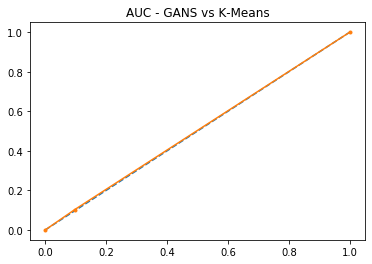

In [148]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


gan_roc_auc = roc_auc_score(ytest, gans_y_pred)
print('AUC: %.3f' % gan_roc_auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(ytest, gans_y_pred)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('AUC - GANS vs K-Means')
#plt.title('AUC - GANS vs Autoencoder')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
# show the plot
plt.show()

### Perfromance Metrics 

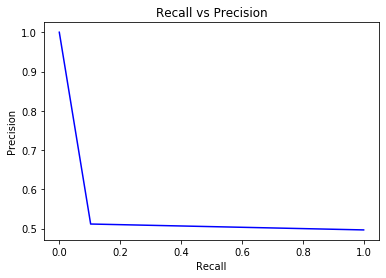

In [149]:
from sklearn.metrics import precision_recall_curve

precision, recall, th = precision_recall_curve(ytest, gans_y_pred)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

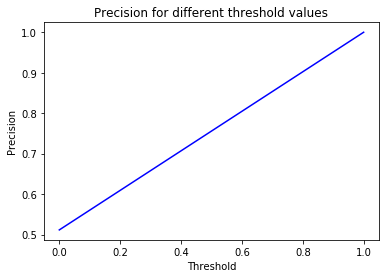

In [150]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

In [128]:
#Merging the GANS label and test Dataset
gans_pca_df = pd.DataFrame(testx).merge(pd.DataFrame(gans_y_pred), how='left', left_index=True, right_index=True)
gans_pca_df.rename(columns={0: 'AnomalyInd'}, inplace=True)

#Merging the GANS label and test Dataset
gans_pca_df = gans_pca_df.merge(pd.DataFrame(gans_score), how='left', left_index=True, right_index=True)
gans_pca_df.rename(columns={0: 'AnomalyScore'}, inplace=True)


In [65]:
#Save Engineered Dataset
pickle.dump(gans_pca_df, open('data/' + dfprefix + '_' + str(datafrac) + '_Unsupervised_GANSLabelData_MC.engineered.pkl','wb'))

#Load pickle data
#gans_pca_df = pickle.load(open('data/' + dfprefix + '_' + str(datafrac) + '_Unsupervised_GANSLabelData.engineered.pkl','rb'))
#auto_pca_df = pickle.load(open('data/Medicare_0.2_Unsupervised_AEData_LelledData.engineered.pkl','rb'))



In [66]:
gans_pca_df.head()

,PracTypeClean_General Surgery,PracTypeClean_Nurse Practitioner,PracTypeClean_Physician Assistant,PracTypeClean_Internal Medicine,PracTypeClean_Pathology,PracTypeClean_Hematology-Oncology,PracTypeClean_Nephrology,PracTypeClean_Ophthalmology,PracTypeClean_Family Practice,PracTypeClean_Cardiovascular Disease (Cardiology),PracTypeClean_Orthopedic Surgery,PracTypeClean_Diagnostic Radiology,PracTypeClean_Emergency Medicine,PracTypeClean_Urology,PracTypeClean_Gastroenterology,PracTypeClean_Interventional Cardiology,PracTypeClean_Audiologist,PracTypeClean_Clinical Laboratory,PracTypeClean_Physical Therapist in Private Practice,PracTypeClean_Neurology,PracTypeClean_Anesthesiology,PracTypeClean_Infectious Disease,PracTypeClean_Neurosurgery,PracTypeClean_Podiatry,PracTypeClean_Thoracic Surgery,PracTypeClean_Vascular Surgery,PracTypeClean_Optometry,PracTypeClean_Ambulatory Surgical Center,PracTypeClean_General Practice,PracTypeClean_Pulmonary Disease,PracTypeClean_Dermatology,PracTypeClean_Physical Medicine and Rehabilitation,"PracTypeClean_Psychologist, Clinical",PracTypeClean_Obstetrics & Gynecology,PracTypeClean_Geriatric Medicine,PracTypeClean_Medical Oncology,PracTypeClean_Rheumatology,PracTypeClean_Radiation Oncology,PracTypeClean_Otolaryngology,PracTypeClean_Interventional Pain Management,PracTypeClean_Certified Registered Nurse Anesthetist (CRNA),PracTypeClean_Mass Immunizer Roster Biller,PracTypeClean_Allergy/ Immunology,PracTypeClean_Interventional Radiology,PracTypeClean_Pain Management,PracTypeClean_Other,PracTypeClean_Psychiatry,PracTypeClean_Independent Diagnostic Testing Facility (IDTF),PracTypeClean_Cardiac Surgery,PracTypeClean_Centralized Flu,PracTypeClean_Endocrinology,PracTypeClean_Clinical Cardiatric Electrophysiology,PracTypeClean_Chiropractic,PracTypeClean_Critical Care (Intensivists),PracTypeClean_Occupational Therapist in Private Practice,PracTypeClean_Ambulance Service Provider,PracTypeClean_Licensed Clinical Social Worker,PracTypeClean_Anesthesiology Assistant,PracTypeClean_Plastic and Reconstructive Surgery,PracTypeClean_Oral Surgery (Dentists only),PracTypeClean_Certified Clinical Nurse Specialist,PracTypeClean_Pediatric Medicine,PracTypeClean_Registered Dietitian or Nutrition Professional,PracTypeClean_Colorectal Surgery (Proctology),AVERAGE_MEDICARE_PAYMENT_AMT,AveragePaymentAmountPerTypeCode,Average_SRVC_CountPerCodeType,Average_UNIQUE_CountPerCodeType,Average_DAY_SRVC_CountPerCodeType,Average_SRVC_DEVIDED_BY_Average_UNIQUE,AnomalyInd,AnomalyScore
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.248,0.429,-0.114,-0.114,-0.183,-0.063,0.000,5.313
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.029,0.031,0.015,0.034,0.281,-0.063,0.000,6.272
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.142,-0.050,-0.137,-0.227,-0.269,-0.063,1.000,8.736
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.068,0.136,-0.115,-0.122,-0.188,-0.063,0.000,6.629
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.161,-0.163,-0.099,-0.094,-0.128,-0.063,0.000,5.975


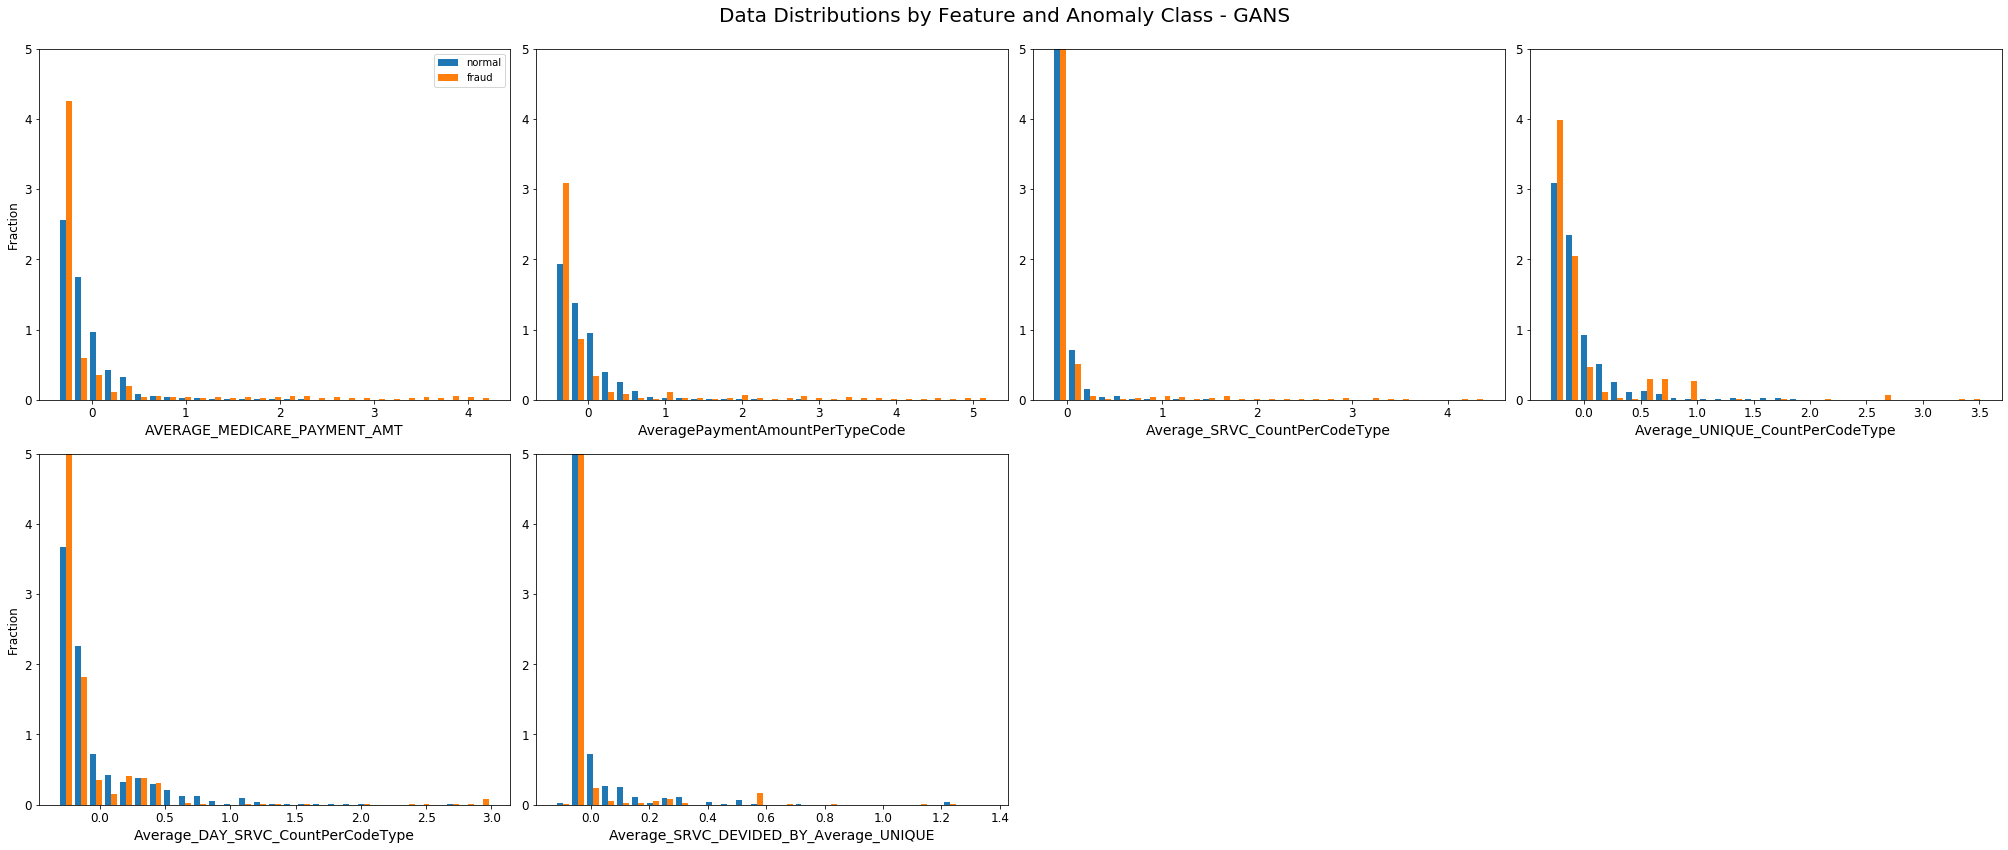

In [101]:
# Plot the data by each feature across the training set - GANS
numerics = ['float16', 'float32', 'float64']
data_cols = mspRedData_Final.select_dtypes(include=numerics).columns
data = gans_pca_df

axarr = [[]]*len(data_cols)
columns = 4
rows = int( np.ceil( len(data_cols) / columns ) )
f, fig = plt.subplots( figsize=(columns*7, rows*6) )

f.suptitle('Data Distributions by Feature and Anomaly Class - GANS', size=20)

for i, col in enumerate(data_cols[:]):
    axarr[i] = plt.subplot2grid( (int(rows), int(columns)), (int(i//columns), int(i%columns)) )
    axarr[i].hist( [ data.loc[ data.AnomalyInd == 0, col ], data.loc[ data.AnomalyInd == 1, col ] ], label=['normal','fraud'], 
                          bins=np.linspace( np.percentile(data[col],0.1), np.percentile(data[col],99.5), 30 ),
                          normed=True )
    axarr[i].set_xlabel(col, size=14)
    axarr[i].set_ylim([0,5])
    axarr[i].tick_params(axis='both', labelsize=12)
    if i == 0: 
        legend = axarr[i].legend()
        legend.get_frame().set_facecolor('white')
    if i%4 != 0 : 
        axarr[i].tick_params(axis='y', left='off', labelleft='off')
    else:
        axarr[i].set_ylabel('Fraction',size=12)

plt.tight_layout(rect=[0,0,1,0.95]) # xmin, ymin, xmax, ymax
plt.savefig(plotloc + 'GANS_DataDistributionsByFeatureandAnomalyClass_Medicare.png')
plt.show()

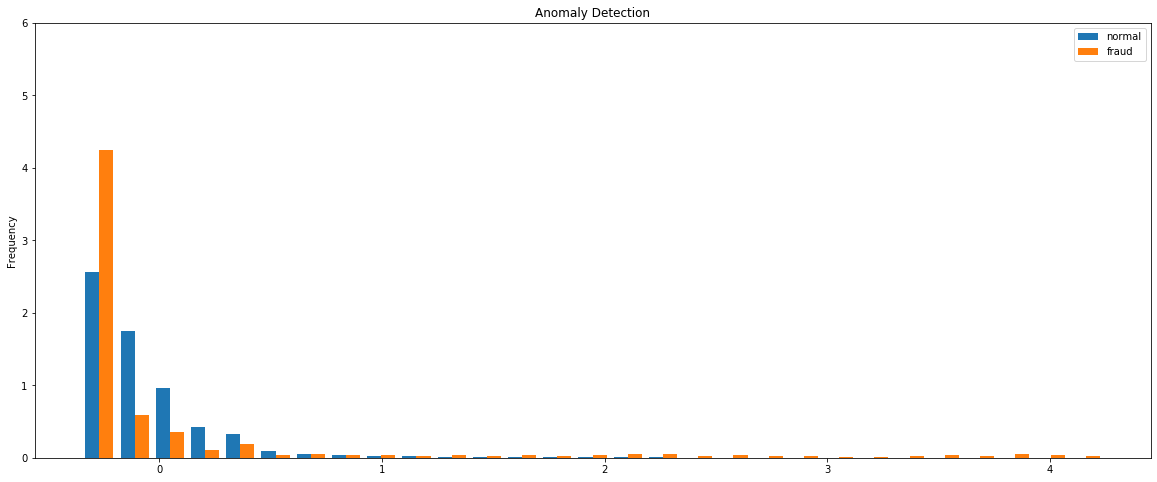

In [102]:
data = gans_pca_df
col = 'AVERAGE_MEDICARE_PAYMENT_AMT'
#Distibution of outliers vs threshold
fig, ax = plt.subplots(figsize=(20,8))
ax.hist([ data.loc[ data.AnomalyInd == 0, col ], data.loc[ data.AnomalyInd == 1, col ] ], label=['normal','fraud'], 
                          bins=np.linspace( np.percentile(data[col],0.1), np.percentile(data[col],99.5), 30 ),
                          normed=True )
#ax.scatter(data.loc[data.AnomalyInd == 1], data.loc[data.AnomalyInd == 1], 'r.')  # Outlier highlights

#ax.plot(data.loc[data.AnomalyInd == 1,"AnomalyScore"], marker="*", linestyle="", alpha=0.8, color="r", label='Anomaly Point')
#ax.hlines(data['AnomalyInd'], ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold - ' + str(threshold_fixed))
ax.legend(loc='upper right')
plt.title('Anomaly Detection')
plt.ylabel('Frequency')
#plt.xlabel([col])
#plt.set_xlabel(col, size=14)
plt.ylim([0,6])
    
#plt.ylim(ymin=0.70,ymax=1)
plt.savefig(plotloc + 'GANS_AnomalyDataDistributionsOfSingleFeature_Medicare.png')
plt.show()

In [69]:
# # Plot the data by each feature across the training set - GANS

# data = gans_pca_df
# #Distibution of outliers vs threshold
# fig, ax = plt.subplots(figsize=(20,8))
# ax.plot(data['AnomalyScore'], linewidth=4, label='Anomaly Score')
# #ax.scatter(data.loc[data.AnomalyInd == 1], data.loc[data.AnomalyInd == 1], 'r.')  # Outlier highlights

# ax.plot(data.loc[data.AnomalyInd == 1,"AnomalyScore"], marker="*", linestyle="", alpha=0.8, color="r", label='Anomaly Point')
# #ax.hlines(data['AnomalyInd'], ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold - ' + str(threshold_fixed))
# ax.legend(loc='upper right')
# plt.title('Anomaly Detection')
# plt.ylabel('Anomaly Value')
# plt.xlabel('Test Sample Data Points') 
# #plt.ylim(ymin=0.70,ymax=1)
# plt.show()

In [70]:
# Plot a filled kernel density estimate
sns.distplot(gans_pca_df.loc[gans_pca_df.AnomalyInd == 1,"AnomalyScore"],rug=True, label = "Anomaly",hist=False, color="r", kde_kws={"shade": True})
# Plot a filled kernel density estimate
sns.distplot(gans_pca_df.loc[gans_pca_df.AnomalyInd == 0,"AnomalyScore"],rug= True, label="Normal" ,hist=False, color="g", kde_kws={"shade": True})


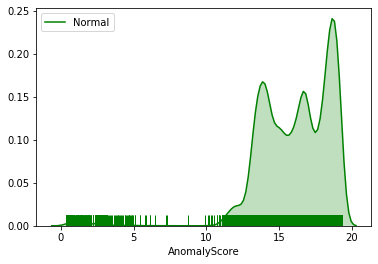

In [129]:
# Plot a filled kernel density estimate
ax = sns.distplot(gans_pca_df.loc[gans_pca_df.AnomalyInd == 0,"AnomalyScore"],rug= True, label="Normal" ,hist=False, color="g", kde_kws={"shade": True})
ax.figure.savefig(plotloc + 'GANS_NormalDataDist_Medicare.png')

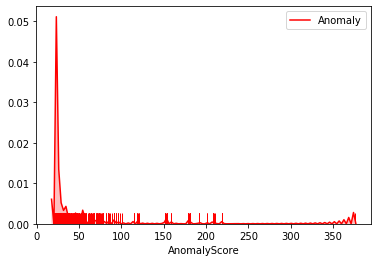

In [130]:
# Plot a filled kernel density estimate
ax = sns.distplot(gans_pca_df.loc[gans_pca_df.AnomalyInd == 1,"AnomalyScore"],rug=True, label = "Anomaly",hist=False, color="r", kde_kws={"shade": True})
ax.figure.savefig(plotloc + 'GANS_AnomalyDataDist_Medicare.png')

In [73]:
# #Save AUC Dataset so it can be used in the GANS Model Notebook
# #pickle.dump(testresult_df, open('data/' + dfprefix + '_' + str(datafrac) + '_MedicareAUC.engineered.pkl','wb'))

# #Load AUC data from other models AE,LOF,iForest and OCSVM
# testresult_df = pickle.load(open('data/' + dfprefix + '_' + str(datafrac) + '_MedicareAUC.engineered.pkl','rb'))


In [74]:
# testresult_df['Class'] = testresult_df.index

In [75]:
# testresult_df = testresult_df.append({'Class': 'GAN',
#                                           'precision':precision,
#                                           'recall':recall,
#                                           'f1':f1,
#                                           'fpr':fpr, 
#                                           'tpr':tpr, 
#                                           'auc':gan_roc_auc}, ignore_index=True)

In [76]:
#testresult_df

In [77]:
# # Set name of the classifiers as index labels
# #testresults = pd.DataFrame(testresults)
# testresult_df.set_index('Class', inplace=True)
# print('============================= Anomaly Detection Models - ROC Curve ===============================' "\n")
# fig = plt.figure(figsize=(6,6))
# plt.clf
# for i in testresult_df.index:
#     plt.plot(testresult_df.loc[i]['fpr'], 
#              testresult_df.loc[i]['tpr'], 
#              label="{}, AUC={:.3f}".format(i, testresult_df.loc[i]['auc']))

    
# plt.plot([0,1], [0,1], color='orange', linestyle='--')

# plt.xticks(np.arange(0.0, 1.1, step=0.1))
# plt.xlabel("False Positive Rate", fontsize=15)
# plt.yticks(np.arange(0.0, 1.1, step=0.1))
# plt.ylabel("True Positive Rate", fontsize=15)
# #plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
# plt.legend(prop={'size':10}, loc='lower right')
# plt.savefig(plotloc + 'AUC_MedicareModelCompare.png')
# plt.show()

In [78]:
#Save Ground Truth Dataset
#pickle.dump(resultlist, open('data/' + 'resultlist.engineered.pkl','wb'))


#Load GROUND TRUTH DATA 
#resultlist = pickle.load(open('data/' + 'resultlist.engineered.pkl','rb'))

In [79]:
# ##Save GANS iteration results to a file
# from datetime import datetime  
# #resultlist = []
# resultlist.append((datetime.today().strftime('%Y-%m-%d'),'GANS - Medicare',gan_auc,precision, recall, f1,gan_acc_score,batch_size, starting_lr, ema_decay, weight, 
#                    method, degree,nb_epochs,batch_size,latent_dim))


In [80]:
resultlist

NameError: name 'resultlist' is not defined

## Plot the GANS Training Losses

In [131]:
losses

[(1.5002632, 0.80217457),
 (1.9818786, 0.478172),
 (3.105407, 0.3053751),
 (4.2687507, 0.15133893),
 (5.372822, 0.08376092),
 (5.7917137, 0.043042965),
 (6.297276, 0.007604073),
 (7.092262, 0.009109966),
 (6.660242, 0.0052428585),
 (6.146889, 0.004634751),
 (6.0578094, 0.0061631887),
 (6.3030896, 0.004420786),
 (6.045029, 0.004167111),
 (5.3276796, 0.011305107),
 (6.206658, 0.00513361),
 (6.332287, 0.003319829),
 (5.9840565, 0.004473605),
 (5.9269133, 0.004792565),
 (5.680741, 0.011924518),
 (5.9332995, 0.004881947),
 (6.0987806, 0.0033822206),
 (5.9522557, 0.003548332),
 (5.923, 0.0040174476),
 (5.804263, 0.004134606),
 (5.7780623, 0.0037263068),
 (5.7745233, 0.0049562682),
 (5.670992, 0.00405839),
 (5.7872667, 0.0044663684),
 (5.7058897, 0.005028639),
 (6.0204315, 0.0033413202),
 (5.8027925, 0.003767464),
 (5.875284, 0.0031077587),
 (5.4695473, 0.004444499),
 (5.7993693, 0.0046252958),
 (5.8373713, 0.0037411067),
 (5.9320674, 0.16587551),
 (5.759105, 0.0053671203),
 (5.5943437, 0.005

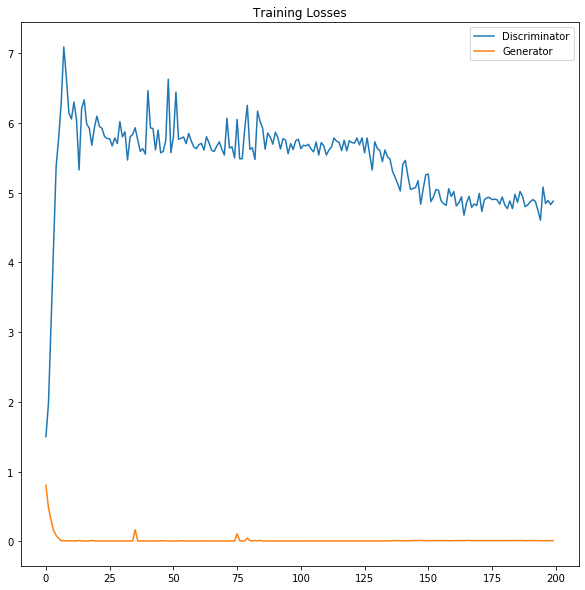

In [132]:

#import plotting
ax = plotting.get_GANSTraningLossesPlot(losses,plotloc, 'GANS - Training Losses')

## Plotting the Generated Data vs Normal Data

In [235]:
testx[testy==1]

,PracTypeClean_General Surgery,PracTypeClean_Nurse Practitioner,PracTypeClean_Physician Assistant,PracTypeClean_Internal Medicine,PracTypeClean_Pathology,PracTypeClean_Hematology-Oncology,PracTypeClean_Nephrology,PracTypeClean_Ophthalmology,PracTypeClean_Family Practice,PracTypeClean_Cardiovascular Disease (Cardiology),PracTypeClean_Orthopedic Surgery,PracTypeClean_Diagnostic Radiology,PracTypeClean_Emergency Medicine,PracTypeClean_Urology,PracTypeClean_Gastroenterology,PracTypeClean_Interventional Cardiology,PracTypeClean_Audiologist,PracTypeClean_Clinical Laboratory,PracTypeClean_Physical Therapist in Private Practice,PracTypeClean_Neurology,PracTypeClean_Anesthesiology,PracTypeClean_Infectious Disease,PracTypeClean_Neurosurgery,PracTypeClean_Podiatry,PracTypeClean_Thoracic Surgery,PracTypeClean_Vascular Surgery,PracTypeClean_Optometry,PracTypeClean_Ambulatory Surgical Center,PracTypeClean_General Practice,PracTypeClean_Pulmonary Disease,PracTypeClean_Dermatology,PracTypeClean_Physical Medicine and Rehabilitation,"PracTypeClean_Psychologist, Clinical",PracTypeClean_Obstetrics & Gynecology,PracTypeClean_Geriatric Medicine,PracTypeClean_Medical Oncology,PracTypeClean_Rheumatology,PracTypeClean_Radiation Oncology,PracTypeClean_Otolaryngology,PracTypeClean_Interventional Pain Management,PracTypeClean_Certified Registered Nurse Anesthetist (CRNA),PracTypeClean_Mass Immunizer Roster Biller,PracTypeClean_Allergy/ Immunology,PracTypeClean_Interventional Radiology,PracTypeClean_Pain Management,PracTypeClean_Other,PracTypeClean_Psychiatry,PracTypeClean_Independent Diagnostic Testing Facility (IDTF),PracTypeClean_Cardiac Surgery,PracTypeClean_Centralized Flu,PracTypeClean_Endocrinology,PracTypeClean_Clinical Cardiatric Electrophysiology,PracTypeClean_Chiropractic,PracTypeClean_Critical Care (Intensivists),PracTypeClean_Occupational Therapist in Private Practice,PracTypeClean_Ambulance Service Provider,PracTypeClean_Licensed Clinical Social Worker,PracTypeClean_Anesthesiology Assistant,PracTypeClean_Plastic and Reconstructive Surgery,PracTypeClean_Oral Surgery (Dentists only),PracTypeClean_Certified Clinical Nurse Specialist,PracTypeClean_Pediatric Medicine,PracTypeClean_Registered Dietitian or Nutrition Professional,PracTypeClean_Colorectal Surgery (Proctology),AVERAGE_MEDICARE_PAYMENT_AMT,AveragePaymentAmountPerTypeCode,Average_SRVC_CountPerCodeType,Average_UNIQUE_CountPerCodeType,Average_DAY_SRVC_CountPerCodeType,Average_SRVC_DEVIDED_BY_Average_UNIQUE
20127,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.360,-0.362,-0.088,-0.167,-0.150,-0.062
20128,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.457,-0.442,8.089,0.162,0.140,-0.062
20129,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.324,-0.325,-0.107,-0.223,-0.204,-0.062
20130,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.756,0.581,-0.120,-0.239,-0.248,-0.062
20131,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.050,-0.040,0.080,0.309,0.510,-0.006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39909,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.199,-0.179,-0.101,-0.114,-0.174,-0.062
39910,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,-0.248,-0.243,-0.006,-0.208,0.188,-0.006
3991

In [259]:
x_cols = pd.DataFrame(trainxx).columns

In [260]:
# Now generate some new data
import data_utils

#batch_size = 500 #Keep the same as batch size
df_columns_len =  len(pd.DataFrame(trainxx).columns)

mu, sigma = 0, 1.0 # mean and standard deviation

x = data_utils.get_batch(pd.DataFrame(trainxx), batch_size, seed = random_seed) #i+j
z = np.random.normal(mu , sigma , size=(batch_size, df_columns_len))
#tf.random_normal([batch_size, latent_dim], mean=0.0, stddev=1.0, name='random_z')

In [261]:
x = pd.DataFrame(x, columns=pd.DataFrame(trainxx).columns)

In [262]:
# testxx = pd.DataFrame(testx, columns=pd.DataFrame(testx).columns)

In [263]:
# def get_disclatentsamples (testxx):

#     latentsamples = []

#     sv = tf.train.Supervisor(logdir=logdir, save_summaries_secs=None,
#                              save_model_secs=120)
#     with sv.managed_session() as sess:

#         geneval_feed_dict = {input_pl: testxx,
#                      is_training_pl: True,
#                      learning_rate:lr}
#         #real_d, inter_layer_real = dis(input_pl, is_training=is_training_pl)
#         ### Generated Data from the Encoder and Generator- Mario 2019/09/02
#         disc_layer = sess.run([inter_layer_real],feed_dict=geneval_feed_dict) #Data from the Discriminator
#         latentsamples.append((testxx.values,disc_layer))
        
#     return latentsamples

In [264]:
# latsamples = get_disclatentsamples (testxx)

In [265]:
x.shape,z.shape

((50, 70), (50, 70))

In [266]:
gensamples = []

sv = tf.train.Supervisor(logdir=logdir, save_summaries_secs=None,
                         save_model_secs=120)
with sv.managed_session() as sess:
    
    geneval_feed_dict = {input_pl: z,
                 is_training_pl: True,
                 learning_rate:lr}
    
    ### Generated Data from the Encoder and Generator- Mario 2019/09/02
    gen_sample = sess.run([generator],feed_dict=geneval_feed_dict) #Data from the Generator
    gensamples.append(gen_sample)

    #enc_sample = sess.run([z_gen],feed_dict=geneval_feed_dict) #Data from the Encoder
    #encsamples.append(enc_sample)  
    ######

INFO:tensorflow:Restoring parameters from GAN_paper/train_logs/medicare/0.1/fm/146/model.ckpt
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Saving checkpoint to path GAN_paper/train_logs/medicare/0.1/fm/146/model.ckpt
INFO:tensorflow:Starting queue runners.


In [267]:
#Extracting data from the list to a dataframe
df_columns =  pd.DataFrame(trainxx).columns

for i in range(len(gensamples)):
    for j in range(len(gensamples[i])):
        gensamples_df = pd.DataFrame(gensamples[i][j], columns=df_columns)
  #      gensamples_df = gensamples[i][j]

#for i in range(len(encsamples)):
 #   for j in range(len(encsamples[i])):
  #      encsamples_df = pd.DataFrame(encsamples[i][j])
#        encsamples_df = encsamples[i][j]



In [268]:
gensamples_df

,PracTypeClean_General Surgery,PracTypeClean_Nurse Practitioner,PracTypeClean_Physician Assistant,PracTypeClean_Internal Medicine,PracTypeClean_Pathology,PracTypeClean_Hematology-Oncology,PracTypeClean_Nephrology,PracTypeClean_Ophthalmology,PracTypeClean_Family Practice,PracTypeClean_Cardiovascular Disease (Cardiology),PracTypeClean_Orthopedic Surgery,PracTypeClean_Diagnostic Radiology,PracTypeClean_Emergency Medicine,PracTypeClean_Urology,PracTypeClean_Gastroenterology,PracTypeClean_Interventional Cardiology,PracTypeClean_Audiologist,PracTypeClean_Clinical Laboratory,PracTypeClean_Physical Therapist in Private Practice,PracTypeClean_Neurology,PracTypeClean_Anesthesiology,PracTypeClean_Infectious Disease,PracTypeClean_Neurosurgery,PracTypeClean_Podiatry,PracTypeClean_Thoracic Surgery,PracTypeClean_Vascular Surgery,PracTypeClean_Optometry,PracTypeClean_Ambulatory Surgical Center,PracTypeClean_General Practice,PracTypeClean_Pulmonary Disease,PracTypeClean_Dermatology,PracTypeClean_Physical Medicine and Rehabilitation,"PracTypeClean_Psychologist, Clinical",PracTypeClean_Obstetrics & Gynecology,PracTypeClean_Geriatric Medicine,PracTypeClean_Medical Oncology,PracTypeClean_Rheumatology,PracTypeClean_Radiation Oncology,PracTypeClean_Otolaryngology,PracTypeClean_Interventional Pain Management,PracTypeClean_Certified Registered Nurse Anesthetist (CRNA),PracTypeClean_Mass Immunizer Roster Biller,PracTypeClean_Allergy/ Immunology,PracTypeClean_Interventional Radiology,PracTypeClean_Pain Management,PracTypeClean_Other,PracTypeClean_Psychiatry,PracTypeClean_Independent Diagnostic Testing Facility (IDTF),PracTypeClean_Cardiac Surgery,PracTypeClean_Centralized Flu,PracTypeClean_Endocrinology,PracTypeClean_Clinical Cardiatric Electrophysiology,PracTypeClean_Chiropractic,PracTypeClean_Critical Care (Intensivists),PracTypeClean_Occupational Therapist in Private Practice,PracTypeClean_Ambulance Service Provider,PracTypeClean_Licensed Clinical Social Worker,PracTypeClean_Anesthesiology Assistant,PracTypeClean_Plastic and Reconstructive Surgery,PracTypeClean_Oral Surgery (Dentists only),PracTypeClean_Certified Clinical Nurse Specialist,PracTypeClean_Pediatric Medicine,PracTypeClean_Registered Dietitian or Nutrition Professional,PracTypeClean_Colorectal Surgery (Proctology),AVERAGE_MEDICARE_PAYMENT_AMT,AveragePaymentAmountPerTypeCode,Average_SRVC_CountPerCodeType,Average_UNIQUE_CountPerCodeType,Average_DAY_SRVC_CountPerCodeType,Average_SRVC_DEVIDED_BY_Average_UNIQUE
0,0.000,-0.004,0.014,-0.000,-0.009,0.015,-0.008,-0.015,0.001,-0.035,0.001,0.006,-0.003,0.016,-0.004,0.019,0.021,-0.006,-0.006,-0.017,-0.005,0.007,0.008,-0.011,-0.016,-0.016,-0.005,-0.134,0.016,0.006,0.014,-0.003,0.026,-0.001,0.529,-0.012,0.006,-0.020,-0.007,0.016,-0.007,-0.007,0.003,0.004,-0.025,-0.029,-0.016,-0.031,-0.048,-0.003,0.008,-0.018,0.000,0.000,-0.004,-0.031,0.015,-0.016,-0.022,0.012,0.017,0.003,0.007,0.582,0.152,0.148,-0.042,-0.144,-0.035,-0.034
1,-0.002,-0.009,0.006,0.006,0.005,-0.000,-0.007,-0.011,0.000,0.005,0.001,0.002,-0.001,-0.001,0.005,-0.004,0.001,0.006,-0.002,0.002,-0.004,-0.003,-0.007,-0.009,0.002,0.008,0.006,0.995,-0.007,0.002,0.004,0.002,-0.005,-0.006,0.002,0.000,-0.009,-0.013,0.003,0.004,-0.001,0.003,-0.003,0.006,-0.004,-0.002,-0.005,-0.006,-0.000,0.001,-0.003,0.004,-0.003,-0.000,0.006,-0.001,-0.003,-0.007,0.004,0.006,0.012,0.001,0.001,-0.006,0.276,0.235,-0.012,0.121,0.001,-0.023
2,0.001,-0.009,0.002,0.017,0.000,-0.003,-0.020,-0.013,-0.016,-0.007,0.000,0.003,0.007,0.003,0.007,-0.013,0.006,0.012,-0.012,-0.013,-0.011,-0.016,-0.029,0.006,-0.004,-0.006,0.002,0.467,-0.015,0.013,0.008,-0.009,0.005,-0.011,0.004,-0.007,0.003,-0.022,0.004,0.023,-0.004,0.004,0.006,-0.003,-0.027,-0.000,0.003,-0.014,-0.003,0.002,-0.008,0.004,0.008,0.004,0.006,0.016,-0.001,0.010,-0.001,0.024,0.014,0.004,-0.001,0.477,0.175,0.152,-0.032,-0.067,-0.033,-0.019
3,0.006,-0.001,0.008,0.003,-0.004,-0.006,-0.013,-0.009,-0.001,-0.010,0.008,0.002,-0.004,-0.000,-0.006,-0.003,0.003,-0.011,-0.002,-0.011,0.0

In [269]:
# #Create the Function to display the real and genrate data along the feature
# def PlotGeneratorData(real_data, gen_data,data_cols):


#     numcols = int(len(data_cols) / 1)
#     #real_data = x
#     #gen_data = gensamples_df
#     #data_cols = data_cols
    
#     for i in range(0,numcols, 1):
#         col1, col2 = i, i+1
#         if i+1 >= numcols : continue

#         f, axarr = plt.subplots(1, 2, figsize=(6,3) )

#         axarr[0].scatter(real_data[data_cols[col1]], real_data[data_cols[col2]] , cmap='plasma')
#         axarr[0].scatter(real_data[data_cols[col1]], real_data[data_cols[col2]] , cmap='plasma')
#         axarr[0].set_xlim(axarr[0].get_xlim()), axarr[1].set_ylim(axarr[0].get_ylim())
#         axarr[0].legend()
#         axarr[0].set_title('Real')
#        # axarr[0].set_ylabel(data_cols[col2]) #OMMIT Y Labels

#         axarr[1].scatter( gen_data[data_cols[col1]], gen_data[data_cols[col2]] , cmap='plasma') 
#         axarr[1].set_xlim(axarr[1].get_xlim()), axarr[1].set_ylim(axarr[1].get_ylim())
#         axarr[1].legend()
#         axarr[1].set_title('Generated') ;
#       #  axarr[1].set_ylabel(data_cols[col2]) #OMMIT Y Labels
        
#        # axarr[2].scatter( enc_data[data_cols[col1]], enc_data[data_cols[col2]] , cmap='plasma') 
#        # axarr[2].legend()
#        # axarr[2].set_title('Encoded') ;
#        # axarr[2].set_ylabel(data_cols[col2])
        

#         #for a in axarr:
#          #   a.set_xlabel(data_cols[col1]) OMMIT X Labels

#     plt.savefig(plotloc + 'GANS_GenerationOfData.png')
#     plt.show()

In [270]:
#Create the Function to display the real and genrate data along the feature
def PlotGeneratorData(real_data, gen_data,data_cols):
    
    numcols = int(len(data_cols) / 3)
    
    for i in range(0,numcols, 1):
        col1, col2 = i, i+1
        if i+1 >= numcols : continue

        #Distibution of outliers vs threshold
        fig, ax = plt.subplots(figsize=(5,5))
        ax.scatter(real_data[data_cols[col1]], real_data[data_cols[col2]] , cmap='plasma', label = 'Real Data')
        ax.scatter(gen_data[data_cols[col1]], gen_data[data_cols[col2]] , cmap='plasma', label = 'Generated Data') 
        ax.set_xlim(ax.get_xlim()), ax.set_ylim(ax.get_ylim())

        ax.legend(loc='upper right')
        plt.title('Real vs Generated Data')
        
        ax.figure.savefig(plotloc + 'GANS_GenerationOfData__Test_Medicare.png')
    plt.show()

In [271]:
def CheckAccuracy(x, g_z, data_cols, label_cols=[], seed=0, with_class=False, data_dim=2 ):

    # Slightly slower code to create dataframes to feed into the xgboost dmatrix formats
    
    # real_samples = pd.DataFrame(x, columns=data_cols+label_cols)
    # gen_samples = pd.DataFrame(g_z, columns=data_cols+label_cols)
    # real_samples['syn_label'] = 0
    # gen_samples['syn_label'] = 1
    
    # training_fraction = 0.5
    # n_real, n_gen = int(len(real_samples)*training_fraction), int(len(gen_samples)*training_fraction)
    # train_df = pd.concat([real_samples[:n_real],gen_samples[:n_gen]],axis=0)
    # test_df = pd.concat([real_samples[n_real:],gen_samples[n_gen:]],axis=0)

    # X_col = test_df.columns[:-1]
    # y_col = test_df.columns[-1]
    # dtrain = xgb.DMatrix(train_df[X_col], train_df[y_col], feature_names=X_col)
    # dtest = xgb.DMatrix(test_df[X_col], feature_names=X_col)
    # y_true = test_df['syn_label']

    dtrain = np.vstack( [ x[:int(len(x)/2)], g_z[:int(len(g_z)/2)] ] ) # Use half of each real and generated set for training
    dlabels = np.hstack( [ np.zeros(int(len(x)/2)), np.ones(int(len(g_z)/2)) ] ) # synthetic labels
    dtest = np.vstack( [ x[int(len(x)/2):], g_z[int(len(g_z)/2):] ] ) # Use the other half of each set for testing
    y_true = dlabels # Labels for test samples will be the same as the labels for training samples, assuming even batch sizes
    
    dtrain = xgb.DMatrix(dtrain, dlabels, feature_names=data_cols+label_cols)
    dtest = xgb.DMatrix(dtest, feature_names=data_cols+label_cols)
    
    xgb_params = {
        # 'tree_method': 'hist', # for faster evaluation
        'max_depth': 4, # for faster evaluation
        'objective': 'binary:logistic',
        'random_state': 0,
        'eval_metric': 'auc', # allows for balanced or unbalanced classes 
        }
    xgb_test = xgb.train(xgb_params, dtrain, num_boost_round=10) # limit to ten rounds for faster evaluation

    y_pred = np.round(xgb_test.predict(dtest))

    # return '{:.2f}'.format(SimpleAccuracy(y_pred, y_true)) # assumes balanced real and generated datasets
    return SimpleAccuracy(y_pred, y_true) # assumes balanced real and generated datasets
    

0.98


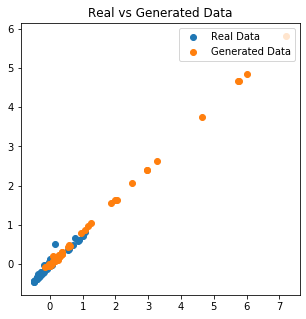

In [272]:
import xgboost as xgb 
# Now we can compare the real and generated data along every feature
#PlotGeneratorData(x, gensamples_df,data_cols) # Only send the Numerical features to be compared...EXcude the Categorical variables
#Print the Accuracy of generated data
label_cols='AnomalyInd'
with_class = False
x_cols = x.columns
print( CheckAccuracy( x, gensamples_df, x_cols, label_cols, seed=0, with_class=with_class, data_dim=len(x_cols) ) )
# Now we can compare the real and generated data along every feature
PlotGeneratorData(x, gensamples_df,data_cols) # Only send the Numerical features to be compared...EXcude the Categorical variables

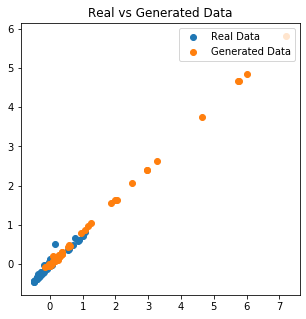

In [273]:
PlotGeneratorData(x, gensamples_df,data_cols)

0


KeyError: 'AnomalyInd'

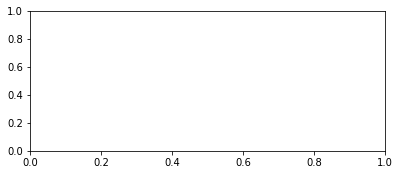

In [95]:
model_steps = [ 0, 20, 40, 60, 80, 100]
rows = len(model_steps)
columns = 2 #(Actual vs Generated)
axarr = [[]]*len(model_steps)
fig = plt.figure(figsize=(14,rows*3))
colors = ['red','blue']
markers = ['o','^']
class_labels = ['Class 0','Class 1']
model_names = ['GAN','CGAN','WGAN','WCGAN']

real_samples = x

for model_step_ix, model_step in enumerate(model_steps):
    print(model_step)
        
    axarr[model_step_ix] = plt.subplot(rows, columns, model_step_ix*columns + 1)
    
    for group, color, marker, label in zip( real_samples.groupby('AnomalyInd'), colors, markers, class_labels ):
        plt.scatter( group[1][[col1]], group[1][[col2]], 
                         label=label, marker=marker, edgecolors=color, facecolors='none' )
    
    plt.title('Actual Fraud Data')
    plt.ylabel(col2) # Only add y label to left plot
    plt.xlabel(col1)
    xlims, ylims = axarr[model_step_ix].get_xlim(), axarr[model_step_ix].get_ylim()
        
    if model_step_ix == 0: 
        legend = plt.legend()
        legend.get_frame().set_facecolor('white')
        
        generator.load_weights( modelsloc + 'weights_gen_' + str(model_step)+'.h5')
        ax = plt.subplot(rows, columns, model_step_ix * columns + 1 + (i+1) )
        
        with sv.managed_session() as sess:
    
            geneval_feed_dict = {input_pl: z,
                         is_training_pl: True,
                         learning_rate:lr}
            ### Generated Data from the Encoder and Generator- Mario 2019/09/02
            gen_sample = sess.run([generator],feed_dict=geneval_feed_dict) #Data from the Generator
            gensamples.append(gen_sample)
    
        g_z = generator_model.predict(z)
        
        gen_samples = pd.DataFrame(g_z, columns=data_cols)
        plt.scatter( gen_samples[[col1]], gen_samples[[col2]], 
                         label=class_labels[0], marker=markers[0], edgecolors=colors[0], facecolors='none' )
        plt.title(model_name)   
        plt.xlabel(data_cols[0])
        ax.set_xlim(xlims), ax.set_ylim(ylims)


plt.suptitle('Comparison of GAN outputs', size=16)
plt.tight_layout(rect=[0.075,0,1,0.95])

# Adding text labels for traning steps
vpositions = np.array([ i._position.bounds[1] for i in axarr ])
vpositions += ((vpositions[0] - vpositions[1]) * 0.35 )
for model_step_ix, model_step in enumerate( model_steps ):
    fig.text( 0.05, vpositions[model_step_ix], 'training\nstep\n'+str(model_step), ha='center', va='center', size=12)

# plt.savefig('plots/Comparison_of_GAN_outputs.png')

# Supervised Models
Used the Test Data Labels from the Unsupervised Step and thereafter split the Data to TRAIN AND TEST used in the SUPERVISED section

## XGBoost Model

In [97]:
#Save Engineered Dataset
#pickle.dump(auto_pca_df, open('data/' + dfprefix + '_' + str(datafrac) + '_Unsupervised_AEData_LelledData.engineered.pkl','wb'))

#Load pickle data
auto_pca_df = pickle.load(open('data/' + dfprefix + '_' + str(datafrac) + '_Unsupervised_AEData_LelledData.engineered.pkl','rb'))


In [56]:
auto_pca_df = gans_pca_df #Setting the dataset

In [58]:
#Using Auto Encoder / GANS as Ground Truth Labels
data = gans_pca_df #auto_pca_df
data.rename(columns={'AnomalyInd': 'Class'}, inplace=True)

In [59]:
data.head()

,PracTypeClean_Internal Medicine,PracTypeClean_Pathology,PracTypeClean_Anesthesiology,PracTypeClean_Family Practice,PracTypeClean_Obstetrics & Gynecology,PracTypeClean_General Surgery,PracTypeClean_Urology,PracTypeClean_Cardiac Surgery,PracTypeClean_Physician Assistant,PracTypeClean_Physical Therapist in Private Practice,...,BENEFICIARY_CC_DIAB_PERCENT,BENEFICIARY_CC_HYPERL_PERCENT,BENEFICIARY_CC_HYPERT_PERCENT,BENEFICIARY_CC_IHD_PERCENT,BENEFICIARY_CC_OST_PERCENT,BENEFICIARY_CC_RAOA_PERCENT,BENEFICIARY_CC_SCHIOT_PERCENT,BENEFICIARY_CC_STRK_PERCENT,BENEFICIARY_AVERAGE_RISK_SCORE,Class
0,0,0,0,0,0,0,0,0,0,0,...,2.128,-0.340,0.338,-0.582,-0.180,-0.680,-0.406,0.053,0.574,0.000
1,0,0,0,0,0,0,0,0,0,0,...,-0.434,-0.130,-0.451,-0.481,2.196,1.775,-0.406,-0.644,-0.374,0.000
2,0,0,0,0,0,0,0,0,0,0,...,0.498,0.552,0.619,0.787,0.137,-0.025,0.948,1.027,0.792,0.000
3,0,0,0,0,0,0,0,0,0,0,...,-0.201,-1.547,-0.507,-0.582,-0.972,-0.352,-0.406,-0.644,-1.063,0.000
4,0,0,0,0,0,0,0,0,0,1,...,-1.831,0.815,0.056,0.077,-0.972,1.230,-0.406,-0.644,-0.769,0.000


In [60]:
# Set up the test and train sets

import xgboost as xgb

np.random.seed(0)

test_cols = data.columns

n_real = np.sum(data.Class==0) # 1053614
n_test = np.sum(data.Class==1) # 353
train_fraction = 0.7
fn_real = int(n_real * train_fraction)
fn_test = int(n_test * train_fraction)

real_samples = data.loc[ data.Class==0, test_cols].sample(n_real, replace=False).reset_index(drop=True)
test_samples = data.loc[ data.Class==1, test_cols].sample(n_test, replace=False).reset_index(drop=True)

train_df = pd.concat([real_samples[:fn_real],test_samples[:fn_test]],axis=0,ignore_index=True).reset_index(drop=True)
# train_df = pd.concat([real_samples[:fn_test],test_samples[:fn_test]],axis=0,ignore_index=True).reset_index(drop=True)

test_df = pd.concat([real_samples[fn_real:],test_samples[fn_test:]],axis=0,ignore_index=True).reset_index(drop=True)
print( 'classes 0, 1: ', n_real, n_test )
print( 'train, test: ', len(train_df), len(test_df) )

X_col = test_df.columns[:-1]
y_col = test_df.columns[-1]
dtrain = xgb.DMatrix(train_df[X_col], train_df[y_col], feature_names=X_col)
dtest = xgb.DMatrix(test_df[X_col], test_df[y_col], feature_names=X_col)



classes 0, 1:  37943 4216
train, test:  29511 12648


In [61]:

# Define some custom metric functions for use with the xgboost algorithm
# https://github.com/dmlc/xgboost/blob/master/demo/guide-python/custom_objective.py

from sklearn.metrics import recall_score, precision_score, roc_auc_score

def recall(preds, dtrain):
    labels = dtrain.get_label()
    return 'recall',  recall_score(labels, np.round(preds))

def precision(preds, dtrain):
    labels = dtrain.get_label()
    return 'precision',  precision_score(labels, np.round(preds))

def roc_auc(preds, dtrain):
    labels = dtrain.get_label()
    return 'roc_auc',  roc_auc_score(labels, preds)



In [62]:

# Run the xgboost algorithm, maximize recall on the test set

results_dict = {}

xgb_params = {
#     'max_depth': 4,
    'objective': 'binary:logistic',
    'random_state': 0,
    'eval_metric': 'auc', # auc, error
#     'tree_method': 'hist'
#     'grow_policy': 'lossguide' # depthwise, lossguide
}

xgb_test = xgb.train(xgb_params, dtrain, num_boost_round=100, 
                     verbose_eval=False,
                     early_stopping_rounds=20, 
                     evals=[(dtrain,'train'),(dtest,'test')],
                     evals_result = results_dict,              
                     feval = recall, maximize=True
#                      feval = roc_auc, maximize=True
                    )

y_pred = xgb_test.predict(dtest, ntree_limit=xgb_test.best_iteration+1)
y_true = test_df['Class'].values
print( 'best iteration: ', xgb_test.best_iteration )
print( recall( y_pred, dtest ) )
print( precision( y_pred, dtest ) )
print( roc_auc( y_pred, dtest ) )
# print( 'Accuracy: {:.3f}'.format(SimpleAccuracy(y_pred, y_true)) )
SimpleMetrics( np.round(y_pred), y_true)

best iteration:  14
('recall', 0.9818181818181818)
('precision', 0.9936)
('roc_auc', 0.9999226361757826)
Confusion Matrix


,Pred 0,Pred 1
True 0,11375,8
True 1,23,1242


Accuracy : 0.9975490196078431
Precision : 0.9936
Recall : 0.9818181818181818


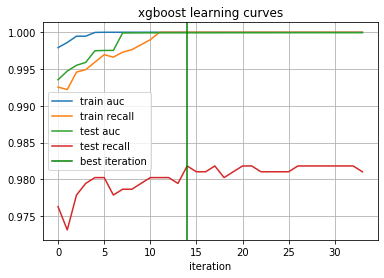

In [63]:

# Let's look at how the metrics changed on the train and test sets as more trees were added

for i in results_dict:
    for err in results_dict[i]:
        plt.plot(results_dict[i][err], label=i+' '+err)   
plt.axvline(xgb_test.best_iteration, c='green', label='best iteration')
plt.xlabel('iteration')
# plt.ylabel(err)
plt.title('xgboost learning curves')
plt.legend()
plt.grid() ;

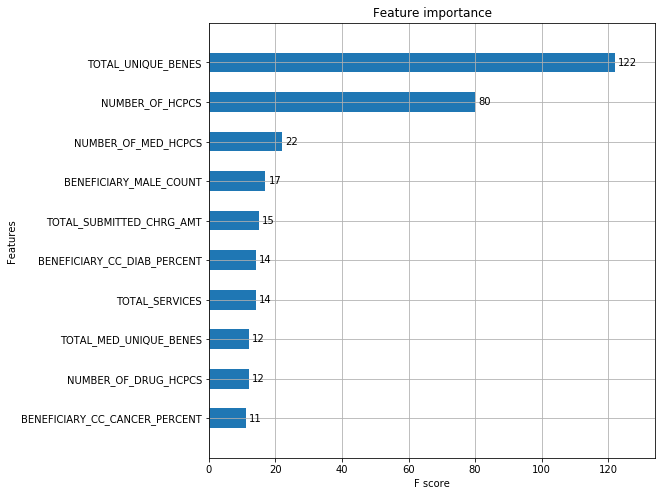

In [64]:
# Plot feature importances

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
xgb.plot_importance(xgb_test, max_num_features=10, height=0.5, ax=ax);

In [65]:

# Generate list of features sorted by importance in detecting fraud
# https://stackoverflow.com/questions/613183/sort-a-python-dictionary-by-value

import operator
x = xgb_test.get_fscore()
sorted_x = sorted(x.items(), key=operator.itemgetter(1), reverse=True)

print( 'Top eight features for fraud detection: ', [ i[0] for i in sorted_x[:8] ] )

sorted_cols = [i[0] for i in sorted_x] + ['Class']
print( sorted_cols )



Top eight features for fraud detection:  ['TOTAL_UNIQUE_BENES', 'NUMBER_OF_HCPCS', 'NUMBER_OF_MED_HCPCS', 'BENEFICIARY_MALE_COUNT', 'TOTAL_SUBMITTED_CHRG_AMT', 'TOTAL_SERVICES', 'BENEFICIARY_CC_DIAB_PERCENT', 'NUMBER_OF_DRUG_HCPCS']
['TOTAL_UNIQUE_BENES', 'NUMBER_OF_HCPCS', 'NUMBER_OF_MED_HCPCS', 'BENEFICIARY_MALE_COUNT', 'TOTAL_SUBMITTED_CHRG_AMT', 'TOTAL_SERVICES', 'BENEFICIARY_CC_DIAB_PERCENT', 'NUMBER_OF_DRUG_HCPCS', 'TOTAL_MED_UNIQUE_BENES', 'BENEFICIARY_FEMALE_COUNT', 'BENEFICIARY_CC_CANCER_PERCENT', 'TOTAL_MEDICARE_ALLOWED_AMT', 'BENEFICIARY_AVERAGE_RISK_SCORE', 'BENEFICIARY_NONDUAL_COUNT', 'BENEFICIARY_CC_CKD_PERCENT', 'TOTAL_MED_MEDICARE_PAYMENT_AMT', 'BENEFICIARY_RACE_WHITE_COUNT', 'BENEFICIARY_CC_IHD_PERCENT', 'BENEFICIARY_AGE_65_74_COUNT', 'BENEFICIARY_RACE_BLACK_COUNT', 'BENEFICIARY_CC_RAOA_PERCENT', 'TOTAL_MED_MEDICARE_ALLOWED_AMT', 'BENEFICIARY_CC_CHF_PERCENT', 'BENEFICIARY_CC_OST_PERCENT', 'BENEFICIARY_AGE_75_84_COUNT', 'BENEFICIARY_CC_ALZRDSD_PERCENT', 'BENEFICIARY_CC_

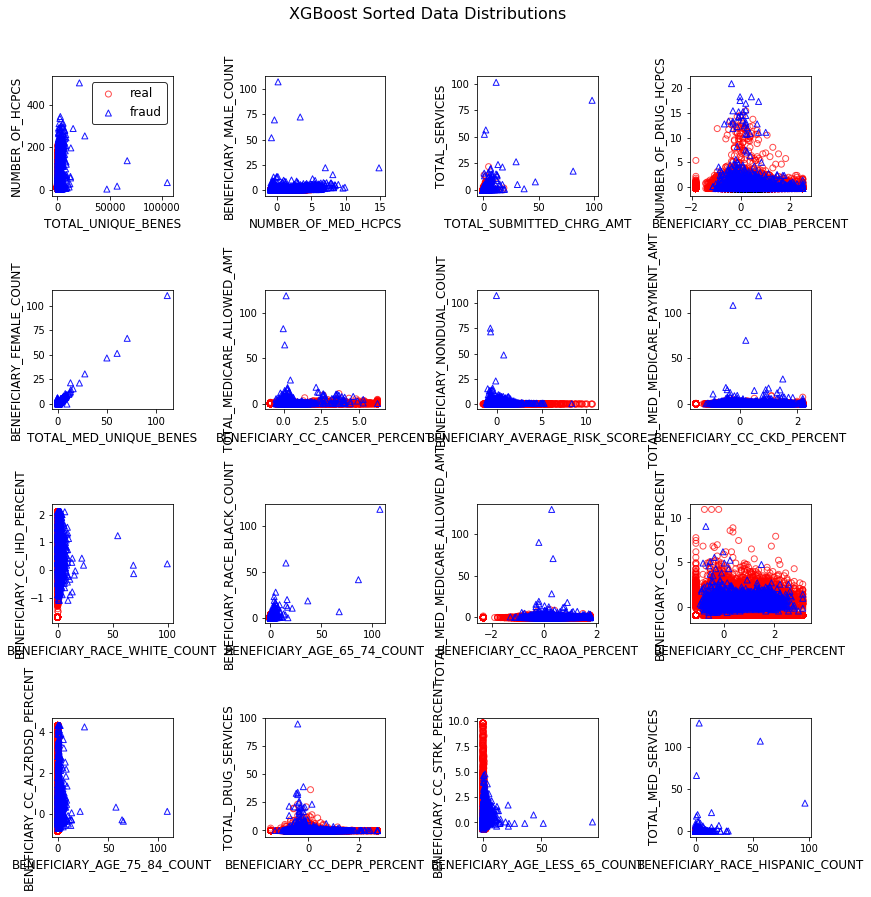

In [66]:

# Plot all of the training data with paired features sorted by importance
# This takes a while

colors = ['red','blue']
markers = ['o','^']
labels = ['real','fraud']
alphas = [0.7, 0.9]

columns = 4
rows = int( np.ceil( len(data_cols) / columns / 2 ) )
plt.figure( figsize=(columns*3, rows*3) )
plt.suptitle('XGBoost Sorted Data Distributions ', size=16)

train = train_df.copy()

for i in range( int(np.floor(len(sorted_x)/3)) )[:]:
    col1, col2 = sorted_x[i*2][0], sorted_x[i*2+1][0]
#     print(i,col1,col2)
    
    plt.subplot(rows,columns,i+1)  
    for group, color, marker, label, alpha in zip( train.groupby('Class'), colors, markers, labels, alphas ):
        plt.scatter( group[1][col1], group[1][col2], 
                         label=label, marker=marker, alpha=alpha,
                         edgecolors=color, facecolors='none' )         
    plt.xlabel(col1, size=12)
    plt.ylabel(col2, size=12)
    plt.tick_params(axis='both', labelsize=10)
    if i == 0: plt.legend(fontsize=12, edgecolor='black')

plt.tight_layout(rect=[0,0,1,0.95]) # xmin, ymin, xmax, ymax
# plt.savefig('plots/XGB_Sorted_Data_Distributions.png')
plt.show()



In [67]:


# Lets look at the effect of the ratio of normal:fraud data in the dataset on recall and roc_auc
# We'll use cross validation to see if differences are significant


np.random.seed(0)

n_real = np.sum(data.Class==0) # 200000
n_test = np.sum(data.Class==1) # 492
real_samples = data.loc[ data.Class==0, test_cols].sample(n_real, replace=False).reset_index(drop=True)
test_samples = data.loc[ data.Class==1, test_cols].sample(n_test, replace=False).reset_index(drop=True)
X_col = data.columns[:-1]
y_col = data.columns[-1]

test_data=[]

# for i in [1]:
# for i in [0.1,0.5,1,2,10]:
for i in np.logspace(-1,2,20):
    print(i)
    train_df = pd.concat([real_samples[:int(n_test*i)],test_samples[:n_test]],axis=0,ignore_index=True).reset_index(drop=True)
    dtrain = xgb.DMatrix(train_df[X_col], train_df[y_col], feature_names=X_col)
    results = xgb.cv(xgb_params, dtrain, 
                     nfold=5, num_boost_round=100, early_stopping_rounds=10, seed=0,
                     feval=recall)
    test_data.append(list([i]) + list(results.tail(1).index) + list(results.tail(1).values[0]))
    
test_data = pd.DataFrame(test_data, columns=list(['ratio','best'])+list(results.columns))
test_data

0.1
0.14384498882876628
0.20691380811147897
0.29763514416313175
0.42813323987193935
0.6158482110660264
0.8858667904100825
1.2742749857031335
1.8329807108324356
2.636650898730358
3.79269019073225
5.455594781168517
7.847599703514611
11.288378916846883
16.23776739188721
23.357214690901213
33.59818286283781
48.32930238571752
69.51927961775606
100.0


,ratio,best,train-auc-mean,train-auc-std,train-recall-mean,train-recall-std,test-auc-mean,test-auc-std,test-recall-mean,test-recall-std
0,0.100,0,0.994,0.001,0.999,0.000,0.992,0.010,0.999,0.001
1,0.144,0,0.996,0.000,0.999,0.000,0.994,0.007,0.999,0.001
2,0.207,0,0.996,0.000,0.999,0.000,0.995,0.004,0.997,0.001
3,0.298,12,1.000,0.000,1.000,0.000,1.000,0.001,0.998,0.001
4,0.428,5,1.000,0.000,1.000,0.000,0.999,0.001,0.996,0.002
5,0.616,1,0.999,0.000,0.999,0.000,0.998,0.002,0.996,0.002
6,0.886,1,0.999,0.000,0.999,0.000,0.999,0.001,0.994,0.003
7,1.274,0,0.999,0.000,0.998,0.001,0.998,0.002,0.994,0.002
8,1.833,0,1.000,0.000,0.997,0.001,0.998,0.001,0.991,0.003
9,2.637,4,1.000,0.000,0.999,0.000,1.000,0.000,0.992,0.003


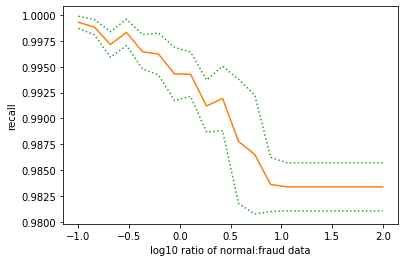

In [68]:

# Recall decreases as more normal data is added

#metric = 'auc'
metric = 'recall'
# xs = test_data['ratio'].values
xs = np.log10(test_data['ratio'].values)
ys = test_data['test-'+metric+'-mean'].values
stds = test_data['test-'+metric+'-std'].values
plt.plot(xs,ys,c='C1')
plt.plot(xs,ys+stds,linestyle=':',c='C2')
plt.plot(xs,ys-stds,linestyle=':',c='C2')
plt.xlabel('log10 ratio of normal:fraud data')
plt.ylabel(metric)
# plt.ylim([0.96,1.01])
plt.show()